In [313]:
from ipywidgets import interact, FloatSlider, RadioButtons,Dropdown,SelectMultiple,FloatRangeSlider
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import h5py
import os
import scipy
import sklearn
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from  sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.

Populating the interactive namespace from numpy and matplotlib


In [314]:
cd /home/chenxupeng/projects/training

/home/chenxupeng/projects/training


In [315]:
wholeannotation = pd.read_table("data/wholeannotation.csv",sep=',')
wholeannotation.head()

,Unnamed: 0,Sample_ID,Disease_status,Sex,Age,Tumor_size(cm),Multiple_tumor,Vascular_invasion,Satellite_nonules,AFP(ng/ml),...,PT,Stage-BCLC,RNA_mass(ng/mlplasma),Batch,spike-in,Seq-mode,DNase1,use,sampleuse,Disease_status_formal
0,0,lulab_249136_B,HCC_before_surgery,M,43,2.8,No,No,0,559.6,...,10.1,A,27.63,7th_201803,NaN,NaN,NaN,1,1,HCC
1,1,lulab_385247_B,HCC_before_surgery,M,54,4,No,No,1,19.61,...,12,A,33.45,4th_201801,NaN,NaN,NaN,1,1,HCC
2,2,lulab_423976_B,HCC_before_surgery,F,60,_,No,Yes,0,4.58,...,15,C,32.66,3nd_201801,NaN,NaN,NaN,1,1,HCC
3,3,lulab_497411_B,HCC_before_surgery,F,70,8,No,No,0,3.45,...,11.3,A,28.32,2nd_201712,0,PE150,N,1,1,HCC
4,4,lulab_497497_B,HCC_before_surgery,M,44,12.3,Yes,No,0,3155,...,11.2,B,34.24,1st_201711,0,PE150,N,1,1,HCC


## prepare data
- four kinds of data
- main and top20
- preprocess

In [316]:
##注意： 经过检验，normalization步骤的sample use是没问题的，在前64个sample中去掉三个sample，这里wholeanno是66个sample，
##在前64个有三个去掉，再去掉post的即为需要的
sampleinduse = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,14,  15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 58, 59, 60])
np.where(wholeannotation['sampleuse'] ==1)[0][:-2]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

#### 需要的43个sample的table！

In [317]:
#需要的43个sample的table！
usetable = wholeannotation.iloc[np.where(wholeannotation['sampleuse'] ==1)[0][:-2]].iloc[sampleinduse]
np.sum(usetable['Disease_status_formal'] =='HCC')

30

In [318]:
np.array(usetable['Stage-BCLC'])

array(['A', 'A', 'C', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A',
       'A', 'B', 'A', 'A', 'C', 'B', 'A', 'B', 'C', 'A', 'B', 'A', 'A',
       'B', 'C', 'A', 'A', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-'], dtype=object)

In [319]:
np.array(usetable['Disease_status_formal'])

array(['HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC',
       'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC',
       'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC', 'HCC',
       'HCC', 'HCC', 'HCC', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD', 'HD',
       'HD', 'HD', 'HD', 'CHB', 'CHB', 'CHB'], dtype=object)

In [320]:
pd.read_table('new_feature/preprocessed/preprocessed_feature'+str(1)+'.csv',sep=',').iloc[:,1:].shape

(43, 1709)

In [321]:
def get_data(featureind=1):
    featuretable=  pd.read_table('new_feature/preprocessed/preprocessed_feature'+str(featureind)+'.csv',sep=',').iloc[:,1:]
    featuretable['lables'][featuretable['lables'] ==2]=0
    return featuretable

def top20_data(featureind=1):
    return np.array(pd.read_table('new_feature/top20/feature'+str(featureind)+'_top20.csv',sep=',').iloc[:,1:]).T
   
def get_concat_data(top20,main):
    main[np.isnan(main)] =0
    print (preprocessing.scale(top20).shape)
    print (preprocessing.scale(main).shape)
    fullfeaturesarray =np.concatenate((preprocessing.scale(main),
                               preprocessing.scale(top20),
                ),axis=1)
    print (fullfeaturesarray.shape)
    return fullfeaturesarray   
def get_feature_name(featureind=1):
    return np.concatenate((get_data(featureind).columns[2:],
                np.array(pd.read_table('new_feature/top20/feature'+str(featureind)+'_top20.csv',sep=',').iloc[:,0])))

In [322]:
get_feature_name(featureind=1).shape

(1727,)

In [323]:
np.array(get_data(featureind=1).iloc[:,2:]).shape

(43, 1707)

In [451]:
binfeaturename

array(['peak_1.12979_0_60', 'peak_10.13027_40_60', 'peak_100.31864_0_73',
       ..., 'peak_997.ENST00000595858.5_1520_1560',
       'peak_998.ENST00000596502.1_320_360',
       'peak_999.ENST00000596663.5_1560_1580'], dtype=object)

In [324]:
binfeaturesarray = get_concat_data(top20_data(featureind=1),np.array(get_data(featureind=1).iloc[:,2:]))

binfeaturename = get_feature_name(featureind=1)
binfeaturenamesplit = np.array([binfeaturename[i].split('__')[0] for i in range(binfeaturename.shape[0])]).astype('object')

(43, 20)
(43, 1707)
(43, 1727)


In [325]:
binfeaturenamesplit[-20:]

array(['peak_189;ENST00000362134.1_0_72',
       'peak_208;ENST00000362201.2_0_80',
       'peak_209;ENST00000362202.3_0_40',
       'peak_211;ENST00000362205.1_0_40',
       'peak_213;ENST00000362215.3_0_68',
       'peak_221;ENST00000362251.4_0_77',
       'peak_228;ENST00000362280.3_0_40',
       'peak_230;ENST00000362283.1_0_70',
       'peak_232;ENST00000362291.1_0_80',
       'peak_236;ENST00000362309.3_0_40',
       'peak_371;ENST00000364908.1_0_80',
       'peak_530;ENST00000384816.1_0_80',
       'peak_608;ENST00000385044.3_0_80',
       'peak_615;ENST00000385054.1_0_80',
       'peak_618;ENST00000385059.1_0_72',
       'peak_630;ENST00000385140.1_0_80',
       'peak_635;ENST00000385201.1_0_80',
       'peak_668;ENST00000385277.1_0_80',
       'peak_1040;ENST00000612171.2_0_68',
       'peak_1183;ENST00000637446.1_0_64'], dtype=object)

# bin and mix, with same gene id's bin, calculate PCC to remove redundancy

In [130]:
binfeaturenamesplituni,binfeaturenamesplitunicounts = np.unique(binfeaturenamesplit,return_counts=True)

In [132]:
binfeaturenamesplitunicounts

array([1, 1, 1, ..., 1, 1, 1])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

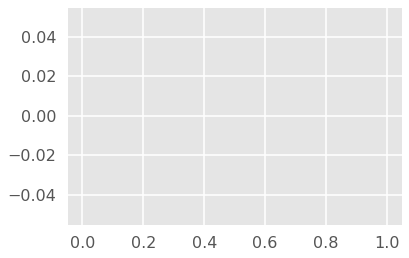

In [131]:
hist(binfeaturenamesplitunicounts[binfeaturenamesplitunicounts>1],bins=50)

In [326]:
def remove_redundancy(arr,thres=0.95):
    '''
    calculate pcc of a m*n array, find redundancy less than thres
    '''
    pcc = {}
    num = arr.shape[0]
    final = np.arange(0,num)
    for i in tqdm(range(num-1)):
        pcc[i] = []
        for j in range(i+1,num):
            #pcc[i].append(pearsonr(arr[i],arr[j])[0])
            if pearsonr(arr[i],arr[j])[0] >thres:
                final = np.setdiff1d(final,np.array([j])) 
    return np.array(final)

In [327]:
retainindforbin = []
for i in tqdm(range(binfeaturenamesplituni.shape[0])):
    unibinind = np.where(binfeaturenamesplit == binfeaturenamesplituni[i])[0]
    if unibinind.shape[0] >1:
        #print (unibinind[remove_redundancy(binfeaturesarray[:,unibinind].T,0.95)])
        print (unibinind)
        retainindforbin.append( unibinind[ remove_redundancy(binfeaturesarray[:,unibinind].T,0.95)])
    elif unibinind.shape[0] ==1:
        retainindforbin.append(unibinind)
        #print (unibinind)
    else:
        print ('something wrong')

HBox(children=(IntProgress(value=0, max=1727), HTML(value='')))

In [328]:
retainindforbin_ = np.array([])
for i in range(len(retainindforbin)):
    retainindforbin_  = np.concatenate((retainindforbin_,retainindforbin[i]))

In [329]:
np.savetxt('new_feature/remove_redundancy/binafterremoveredundancy_1.txt',np.array(retainindforbin_),fmt='%d')

In [330]:
retainindforbin_ =retainindforbin_.astype('int')
retainindforbin_.shape
binfeaturesarray = binfeaturesarray[:,retainindforbin_]
binfeaturenamesplit = binfeaturenamesplit[retainindforbin_]
binfeaturename = binfeaturename[retainindforbin_]

In [331]:
binfeaturename

array(['peak_1.12979_0_60', 'peak_10.13027_40_60', 'peak_100.31864_0_73',
       ..., 'peak_997.ENST00000595858.5_1520_1560',
       'peak_998.ENST00000596502.1_320_360',
       'peak_999.ENST00000596663.5_1560_1580'], dtype=object)

In [332]:
binfeaturenamesplit

array(['peak_1.12979_0_60', 'peak_10.13027_40_60', 'peak_100.31864_0_73',
       ..., 'peak_997.ENST00000595858.5_1520_1560',
       'peak_998.ENST00000596502.1_320_360',
       'peak_999.ENST00000596663.5_1560_1580'], dtype=object)

In [445]:
nametranslation = pd.read_table('/Share/home/shibinbin/projects/exRNA/data/annotation/transcript_table/all.txt',dtype='str')


In [475]:
np.where(nametranslation['gene_name']=='1')

(array([], dtype=int64),)

In [448]:
nametranslation['gene_name']

0                piR-hsa-18438
1                    MIR6859-1
2                 piR-hsa-7508
3                piR-hsa-23387
4                  MIR1302-2HG
5                  MIR1302-2HG
6                    MIR1302-2
7                piR-hsa-27273
8                      FAM138A
9                      FAM138A
10               piR-hsa-20283
11               piR-hsa-20282
12               piR-hsa-20281
13               piR-hsa-32653
14               piR-hsa-22415
15               piR-hsa-30937
16               piR-hsa-10337
17                       OR4F5
18                       OR4F5
19                piR-hsa-1745
20               piR-hsa-23999
21               piR-hsa-24909
22               piR-hsa-25715
23               piR-hsa-29260
24               piR-hsa-12461
25               piR-hsa-20420
26                  AL627309.1
27                  AL627309.3
28                  AL627309.1
29             piR-hsa-23387_2
                  ...         
1040215         piR-hsa-4832_3
1040216 

In [52]:
for i in tqdm(np.where(nametranslation[:,2] =='Y_RNA')):
    nametranslation[i,2] = nametranslation[i,1]
np.savetxt('new_feature/name_translation.txt',nametranslation,fmt='%s')

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

In [450]:
binfeaturenamesplit

array(['peak_1.12979_0_60', 'peak_10.13027_40_60', 'peak_100.31864_0_73',
       ..., 'peak_997.ENST00000595858.5_1520_1560',
       'peak_998.ENST00000596502.1_320_360',
       'peak_999.ENST00000596663.5_1560_1580'], dtype=object)

In [449]:
np.where(nametranslation['transcript_id'] ==binfeaturenamesplit[10])

(array([], dtype=int64),)

In [439]:
nametranslation[:,4]

array(['DDX11L1', 'DDX11L1', 'WASH7P', ..., '28569', '35969', '26266'],
      dtype='<U18')

## 去掉featurename前缀 full bin

In [333]:
stripfullfeaturename = np.array(pd.Series(fullfeaturename).str.extract('^.+RNA_(.*)$', expand=False))

NameError: name 'fullfeaturename' is not defined

In [461]:
stripbinfeaturename = np.array(pd.Series(binfeaturename).str.extract('^([^\.]+)\.(.*)_([0-9]+)_([0-9]+)$', expand=False))[:,1]

In [335]:
stripbinfeaturename  = np.array(pd.Series(binfeaturename).str.extract('^.+RNA_(.*)$', expand=False))

## 对应好，改name，然后加上full或者bin

In [458]:
np.array(nametranslation['transcript_id'])

array(['piR-hsa-18438', 'ENST00000619216.1', 'piR-hsa-7508', ...,
       'piR-hsa-15406_18975', 'piR-hsa-7508_9', 'piR-hsa-14170_5'],
      dtype=object)

In [462]:
stripbinfeaturename

array(['12979', '13027', '31864', ..., 'ENST00000595858.5',
       'ENST00000596502.1', 'ENST00000596663.5'], dtype=object)

In [477]:
binnametranslated = np.copy(stripbinfeaturename)
for i in tqdm(range(stripbinfeaturename.shape[0])):
    indtmp = np.where(np.array(nametranslation['transcript_id']) ==stripbinfeaturename[i])[0]
    if indtmp.shape[0]!=0:
        print (i)
        binnametranslated[i] = np.array(nametranslation['transcript_name'])[indtmp[0]]


  0%|          | 2/1727 [00:00<02:20, 12.25it/s]

0
1
2



  0%|          | 6/1727 [00:00<01:50, 15.64it/s]

3
4
5
6



  1%|          | 10/1727 [00:00<01:59, 14.31it/s]

7
8
9



  1%|          | 12/1727 [00:00<02:06, 13.61it/s]

10
11
12



  1%|          | 16/1727 [00:01<02:05, 13.67it/s]

13
14
15



  1%|          | 18/1727 [00:01<02:04, 13.71it/s]

16
17
18



  1%|▏         | 22/1727 [00:01<02:05, 13.57it/s]

19
20
21



  1%|▏         | 24/1727 [00:01<02:05, 13.56it/s]

22
23
24



  2%|▏         | 28/1727 [00:02<02:06, 13.48it/s]

25
26
27



  2%|▏         | 30/1727 [00:02<02:07, 13.34it/s]

28
29
30



  2%|▏         | 34/1727 [00:02<02:06, 13.41it/s]

31
32
33



  2%|▏         | 36/1727 [00:02<02:05, 13.44it/s]

34
35
36



  2%|▏         | 40/1727 [00:02<02:04, 13.50it/s]

37
38
39
40



  3%|▎         | 44/1727 [00:03<02:02, 13.71it/s]

41
42
43
44



  3%|▎         | 48/1727 [00:03<02:00, 13.90it/s]

45
46
48



  3%|▎         | 52/1727 [00:03<02:01, 13.74it/s]

49
50
51
52



  3%|▎         | 56/1727 [00:04<01:59, 13.94it/s]

53
54
55
56



  3%|▎         | 60/1727 [00:04<01:58, 14.08it/s]

57
58
59
60



  4%|▎         | 64/1727 [00:04<01:57, 14.17it/s]

61
62
63
64



  4%|▍         | 68/1727 [00:04<01:55, 14.31it/s]

65
66
67
68



  4%|▍         | 72/1727 [00:04<01:54, 14.42it/s]

69
70
71
72



  4%|▍         | 76/1727 [00:05<01:53, 14.51it/s]

73
74
75
76



  5%|▍         | 80/1727 [00:05<01:52, 14.60it/s]

77
78
79
80



  5%|▍         | 84/1727 [00:05<01:51, 14.71it/s]

81
82
83
84



  5%|▌         | 88/1727 [00:05<01:50, 14.82it/s]

85
86
87
88



  5%|▌         | 92/1727 [00:06<01:49, 14.88it/s]

89
90
91
92



  6%|▌         | 96/1727 [00:06<01:49, 14.96it/s]

93
94
95
96



  6%|▌         | 100/1727 [00:06<01:48, 15.05it/s]

97
98
99
100



  6%|▌         | 104/1727 [00:06<01:47, 15.07it/s]

101
102
103



  6%|▋         | 108/1727 [00:07<01:46, 15.18it/s]

104
105
106
107



  6%|▋         | 112/1727 [00:07<01:45, 15.28it/s]

108
109
110
111



  7%|▋         | 116/1727 [00:07<01:44, 15.38it/s]

112
113
114
115



  7%|▋         | 120/1727 [00:07<01:43, 15.47it/s]

116
117
118
119



  7%|▋         | 124/1727 [00:07<01:43, 15.52it/s]

120
121
122
123



  7%|▋         | 128/1727 [00:08<01:42, 15.62it/s]

124
125
126
127



  8%|▊         | 132/1727 [00:08<01:41, 15.68it/s]

128
129
130
131



  8%|▊         | 134/1727 [00:08<01:41, 15.62it/s]

132
133
134



  8%|▊         | 138/1727 [00:08<01:41, 15.61it/s]

135
136
137
138



  8%|▊         | 142/1727 [00:09<01:41, 15.60it/s]

139
140
141



  8%|▊         | 144/1727 [00:09<01:41, 15.57it/s]

142
143
144
145



  9%|▊         | 148/1727 [00:09<01:41, 15.58it/s]

146
147
148
149



  9%|▉         | 152/1727 [00:09<01:41, 15.56it/s]

150
151
152



  9%|▉         | 156/1727 [00:10<01:41, 15.52it/s]

153
154
155
156



  9%|▉         | 160/1727 [00:10<01:40, 15.53it/s]

157
158
159
160



  9%|▉         | 164/1727 [00:10<01:40, 15.50it/s]

161
162
163



 10%|▉         | 166/1727 [00:10<01:40, 15.50it/s]

164
165
166
167



 10%|▉         | 170/1727 [00:10<01:40, 15.50it/s]

168
169
170
171



 10%|█         | 174/1727 [00:11<01:40, 15.50it/s]

172
173
174
175



 10%|█         | 178/1727 [00:11<01:40, 15.49it/s]

176
177
178
179



 11%|█         | 182/1727 [00:11<01:39, 15.46it/s]

180
181
182



 11%|█         | 186/1727 [00:12<01:39, 15.46it/s]

183
184
185
186



 11%|█         | 188/1727 [00:12<01:39, 15.47it/s]

187
188
189



 11%|█         | 194/1727 [00:12<01:39, 15.44it/s]

190
191
192
193



 11%|█▏        | 196/1727 [00:12<01:39, 15.41it/s]

194
195
196
197



 12%|█▏        | 202/1727 [00:13<01:38, 15.51it/s]

198
199
200
201



 12%|█▏        | 204/1727 [00:13<01:38, 15.53it/s]

202
203
204
206



 12%|█▏        | 211/1727 [00:13<01:36, 15.65it/s]

207
208
209
210



 12%|█▏        | 215/1727 [00:13<01:36, 15.70it/s]

211
212
213
214



 13%|█▎        | 218/1727 [00:13<01:35, 15.75it/s]

215
216
217
218



 13%|█▎        | 223/1727 [00:14<01:35, 15.82it/s]

219
220
221
222
223



 13%|█▎        | 227/1727 [00:14<01:34, 15.87it/s]

224
225
226
227



 13%|█▎        | 230/1727 [00:14<01:34, 15.92it/s]

228
229
230
231
232



 14%|█▎        | 235/1727 [00:14<01:33, 15.99it/s]

233
234
235
236
237



 14%|█▍        | 241/1727 [00:14<01:32, 16.08it/s]

238
239



 15%|█▍        | 252/1727 [00:15<01:29, 16.43it/s]

246



 15%|█▌        | 262/1727 [00:15<01:27, 16.72it/s]

257



 16%|█▌        | 274/1727 [00:16<01:25, 17.05it/s]

268



 16%|█▋        | 282/1727 [00:16<01:23, 17.27it/s]


279


 17%|█▋        | 294/1727 [00:16<01:21, 17.59it/s]

290



 18%|█▊        | 306/1727 [00:17<01:19, 17.90it/s]

301



 18%|█▊        | 318/1727 [00:17<01:17, 18.20it/s]

312



 19%|█▉        | 326/1727 [00:17<01:16, 18.38it/s]

323



 20%|█▉        | 338/1727 [00:18<01:14, 18.61it/s]

334
335



 20%|██        | 349/1727 [00:18<01:13, 18.82it/s]

346



 21%|██        | 361/1727 [00:18<01:11, 19.08it/s]

357



 22%|██▏       | 373/1727 [00:19<01:10, 19.33it/s]

368



 22%|██▏       | 385/1727 [00:19<01:08, 19.56it/s]

379



 23%|██▎       | 393/1727 [00:19<01:07, 19.70it/s]

390



 23%|██▎       | 405/1727 [00:20<01:06, 19.90it/s]

401



 24%|██▍       | 417/1727 [00:20<01:05, 20.05it/s]

412



 25%|██▍       | 428/1727 [00:21<01:04, 20.21it/s]

423



 25%|██▌       | 437/1727 [00:21<01:03, 20.31it/s]

434



 26%|██▌       | 448/1727 [00:21<01:02, 20.45it/s]

445
446



 27%|██▋       | 462/1727 [00:22<01:01, 20.64it/s]

457



 27%|██▋       | 473/1727 [00:22<01:00, 20.78it/s]

468



 28%|██▊       | 484/1727 [00:23<00:59, 20.91it/s]

479



 29%|██▊       | 495/1727 [00:23<00:58, 21.05it/s]

490



 29%|██▉       | 506/1727 [00:23<00:57, 21.18it/s]

501



 30%|██▉       | 516/1727 [00:24<00:57, 21.24it/s]

512



 31%|███       | 528/1727 [00:24<00:56, 21.29it/s]

523



 31%|███       | 539/1727 [00:25<00:55, 21.41it/s]

534



 32%|███▏      | 548/1727 [00:25<00:55, 21.41it/s]

545



 32%|███▏      | 559/1727 [00:25<00:54, 21.51it/s]

556
557



 33%|███▎      | 574/1727 [00:26<00:53, 21.66it/s]

568



 34%|███▍      | 585/1727 [00:26<00:52, 21.76it/s]

579



 34%|███▍      | 595/1727 [00:27<00:51, 21.84it/s]

590



 35%|███▌      | 606/1727 [00:27<00:51, 21.93it/s]

601



 36%|███▌      | 617/1727 [00:28<00:50, 22.03it/s]

612



 36%|███▋      | 628/1727 [00:28<00:49, 22.13it/s]

623



 37%|███▋      | 638/1727 [00:28<00:49, 22.20it/s]

634



 38%|███▊      | 648/1727 [00:29<00:48, 22.27it/s]

645



 38%|███▊      | 659/1727 [00:29<00:47, 22.35it/s]

656



 39%|███▊      | 669/1727 [00:29<00:47, 22.40it/s]

667
668



 40%|███▉      | 683/1727 [00:30<00:46, 22.50it/s]

679



 40%|████      | 693/1727 [00:30<00:45, 22.56it/s]

690



 41%|████      | 706/1727 [00:31<00:45, 22.64it/s]

701



 41%|████▏     | 716/1727 [00:31<00:44, 22.69it/s]

712



 42%|████▏     | 726/1727 [00:31<00:43, 22.75it/s]

723



 43%|████▎     | 740/1727 [00:32<00:43, 22.85it/s]

734



 43%|████▎     | 749/1727 [00:32<00:42, 22.89it/s]

745



 44%|████▍     | 760/1727 [00:33<00:42, 22.96it/s]

756



 45%|████▍     | 772/1727 [00:33<00:41, 23.01it/s]

767



 45%|████▌     | 782/1727 [00:33<00:41, 23.05it/s]

778
779



 46%|████▌     | 796/1727 [00:34<00:40, 23.13it/s]

790



 47%|████▋     | 806/1727 [00:34<00:39, 23.13it/s]

801



 47%|████▋     | 812/1727 [00:35<00:39, 23.11it/s]

810
811
812
813



 47%|████▋     | 815/1727 [00:35<00:39, 23.07it/s]

814
815
816
817



 47%|████▋     | 820/1727 [00:35<00:39, 22.99it/s]

818
819
820



 48%|████▊     | 824/1727 [00:35<00:39, 22.92it/s]

821
822
823



 48%|████▊     | 826/1727 [00:36<00:39, 22.87it/s]

824
825
826



 48%|████▊     | 830/1727 [00:36<00:39, 22.80it/s]

828
829
830



 48%|████▊     | 834/1727 [00:36<00:39, 22.72it/s]

831
832
833



 48%|████▊     | 836/1727 [00:36<00:39, 22.68it/s]

834
835
836



 49%|████▊     | 840/1727 [00:37<00:39, 22.62it/s]

837
838
839
840



 49%|████▉     | 844/1727 [00:37<00:39, 22.55it/s]

841
842
843



 49%|████▉     | 846/1727 [00:37<00:39, 22.52it/s]

844
845
846



 49%|████▉     | 850/1727 [00:37<00:39, 22.46it/s]

847
848



 49%|████▉     | 854/1727 [00:38<00:38, 22.44it/s]

851
852
854



 50%|████▉     | 858/1727 [00:38<00:38, 22.37it/s]

856
857
858



 50%|████▉     | 862/1727 [00:38<00:38, 22.29it/s]

859
860
861



 50%|█████     | 866/1727 [00:38<00:38, 22.26it/s]

862
863
865



 50%|█████     | 868/1727 [00:39<00:38, 22.24it/s]

866
867
868
869



 50%|█████     | 872/1727 [00:39<00:38, 22.20it/s]

870
872
873



 51%|█████     | 878/1727 [00:39<00:38, 22.15it/s]

875
877
878



 51%|█████     | 882/1727 [00:39<00:38, 22.12it/s]

879
881
882



 51%|█████▏    | 886/1727 [00:40<00:38, 22.07it/s]

883
884
885



 51%|█████▏    | 888/1727 [00:40<00:38, 22.05it/s]

886
887
888
889



 52%|█████▏    | 892/1727 [00:40<00:37, 22.00it/s]

890
891
892
893



 52%|█████▏    | 896/1727 [00:40<00:37, 21.96it/s]

894
895
896
897



 52%|█████▏    | 900/1727 [00:41<00:37, 21.92it/s]

898
899
900



 52%|█████▏    | 904/1727 [00:41<00:37, 21.88it/s]

901
902
903
904



 53%|█████▎    | 908/1727 [00:41<00:37, 21.87it/s]

905
906
907
908



 53%|█████▎    | 912/1727 [00:41<00:37, 21.85it/s]

909
910
911
912



 53%|█████▎    | 916/1727 [00:41<00:37, 21.83it/s]

913
914
915
916



 53%|█████▎    | 920/1727 [00:42<00:36, 21.82it/s]

917
918
919
920



 54%|█████▎    | 924/1727 [00:42<00:36, 21.80it/s]

921
922
923
924



 54%|█████▎    | 928/1727 [00:42<00:36, 21.79it/s]

925
926
927
928



 54%|█████▍    | 932/1727 [00:42<00:36, 21.78it/s]

929
930
931
932



 54%|█████▍    | 936/1727 [00:43<00:36, 21.76it/s]

933
934
935
936



 54%|█████▍    | 940/1727 [00:43<00:36, 21.75it/s]

937
938
939
940



 55%|█████▍    | 944/1727 [00:43<00:36, 21.74it/s]

941
942
943
944



 55%|█████▍    | 948/1727 [00:43<00:35, 21.72it/s]

945
946
947
948



 55%|█████▌    | 953/1727 [00:43<00:35, 21.71it/s]

949
950
951
952



 55%|█████▌    | 957/1727 [00:44<00:35, 21.70it/s]

953
954
955
956



 56%|█████▌    | 961/1727 [00:44<00:35, 21.68it/s]

957
958
959
960



 56%|█████▌    | 965/1727 [00:44<00:35, 21.67it/s]

961
962
963
964



 56%|█████▌    | 969/1727 [00:44<00:35, 21.65it/s]

965
966
967
968



 56%|█████▋    | 973/1727 [00:44<00:34, 21.64it/s]

969
970
971
972



 57%|█████▋    | 977/1727 [00:45<00:34, 21.63it/s]

973
974
975
976



 57%|█████▋    | 981/1727 [00:45<00:34, 21.60it/s]

977
978
979
980



 57%|█████▋    | 985/1727 [00:45<00:34, 21.58it/s]

981
982
983
984



 57%|█████▋    | 989/1727 [00:45<00:34, 21.56it/s]

985
986
987
988



 57%|█████▋    | 993/1727 [00:46<00:34, 21.55it/s]

989
990
991
992



 58%|█████▊    | 997/1727 [00:46<00:33, 21.53it/s]

993
994
995
996



 58%|█████▊    | 1001/1727 [00:46<00:33, 21.51it/s]

997
998
999
1000



 58%|█████▊    | 1005/1727 [00:46<00:33, 21.49it/s]

1001
1002
1003
1004



 58%|█████▊    | 1009/1727 [00:46<00:33, 21.48it/s]

1005
1006
1007
1008



 59%|█████▊    | 1013/1727 [00:47<00:33, 21.46it/s]

1009
1010
1011
1012



 59%|█████▉    | 1017/1727 [00:47<00:33, 21.44it/s]

1013
1014
1015
1016



 59%|█████▉    | 1021/1727 [00:47<00:32, 21.43it/s]

1017
1018
1019
1020



 59%|█████▉    | 1025/1727 [00:47<00:32, 21.41it/s]

1021
1022
1023
1024



 60%|█████▉    | 1029/1727 [00:48<00:32, 21.39it/s]

1025
1026
1027
1028



 60%|█████▉    | 1032/1727 [00:48<00:32, 21.39it/s]

1029
1031
1032



 60%|█████▉    | 1036/1727 [00:48<00:32, 21.37it/s]

1033
1034
1035
1036



 60%|██████    | 1040/1727 [00:48<00:32, 21.32it/s]

1037
1038
1039



 60%|██████    | 1044/1727 [00:49<00:32, 21.29it/s]

1040
1041
1042
1043



 61%|██████    | 1048/1727 [00:49<00:31, 21.28it/s]

1044
1045
1046
1047



 61%|██████    | 1052/1727 [00:49<00:31, 21.26it/s]

1048
1049
1050
1051



 61%|██████    | 1056/1727 [00:49<00:31, 21.25it/s]

1052
1053
1054
1055



 61%|██████▏   | 1060/1727 [00:49<00:31, 21.23it/s]

1056
1057
1058
1059



 62%|██████▏   | 1064/1727 [00:50<00:31, 21.22it/s]

1060
1061
1062
1063



 62%|██████▏   | 1068/1727 [00:50<00:31, 21.20it/s]

1064
1065
1066
1067



 62%|██████▏   | 1070/1727 [00:50<00:31, 21.19it/s]

1068
1069
1070
1071



 62%|██████▏   | 1074/1727 [00:50<00:30, 21.16it/s]

1072
1073
1074



 62%|██████▏   | 1078/1727 [00:51<00:30, 21.12it/s]

1075
1076
1077
1078



 63%|██████▎   | 1082/1727 [00:51<00:30, 21.11it/s]

1079
1080
1081
1082



 63%|██████▎   | 1086/1727 [00:51<00:30, 21.10it/s]

1083
1084
1085
1086



 63%|██████▎   | 1090/1727 [00:51<00:30, 21.09it/s]

1087
1088
1089
1090



 63%|██████▎   | 1094/1727 [00:51<00:30, 21.07it/s]

1091
1092
1093
1094



 64%|██████▎   | 1098/1727 [00:52<00:29, 21.06it/s]

1095
1096
1097
1098



 64%|██████▍   | 1102/1727 [00:52<00:29, 21.05it/s]

1099
1100
1101
1102



 64%|██████▍   | 1106/1727 [00:52<00:29, 21.03it/s]

1103
1104
1105
1106



 64%|██████▍   | 1110/1727 [00:52<00:29, 21.02it/s]

1107
1108
1109
1110



 65%|██████▍   | 1114/1727 [00:53<00:29, 21.01it/s]

1111
1112
1113
1114



 65%|██████▍   | 1118/1727 [00:53<00:29, 21.00it/s]

1115
1116
1117
1118



 65%|██████▍   | 1122/1727 [00:53<00:28, 20.98it/s]

1119
1120
1121
1122



 65%|██████▌   | 1126/1727 [00:53<00:28, 20.97it/s]

1123
1124
1125
1126



 65%|██████▌   | 1130/1727 [00:53<00:28, 20.96it/s]

1127
1128
1129
1130



 66%|██████▌   | 1134/1727 [00:54<00:28, 20.95it/s]

1131
1132
1133
1134



 66%|██████▌   | 1138/1727 [00:54<00:28, 20.94it/s]

1135
1136
1137
1138



 66%|██████▌   | 1142/1727 [00:54<00:27, 20.93it/s]

1139
1140
1141
1142



 66%|██████▋   | 1146/1727 [00:54<00:27, 20.91it/s]

1143
1144
1145
1146



 67%|██████▋   | 1150/1727 [00:55<00:27, 20.89it/s]

1147
1148
1149



 67%|██████▋   | 1152/1727 [00:55<00:27, 20.88it/s]

1150
1151
1152



 67%|██████▋   | 1156/1727 [00:55<00:27, 20.84it/s]

1153
1154
1155



 67%|██████▋   | 1158/1727 [00:55<00:27, 20.83it/s]

1156
1157
1158



 67%|██████▋   | 1162/1727 [00:55<00:27, 20.80it/s]

1159
1160
1161
1162



 68%|██████▊   | 1166/1727 [00:56<00:26, 20.78it/s]

1163
1164
1165
1166



 68%|██████▊   | 1170/1727 [00:56<00:26, 20.77it/s]

1167
1168
1169
1170



 68%|██████▊   | 1174/1727 [00:56<00:26, 20.77it/s]

1171
1172
1173
1174



 68%|██████▊   | 1178/1727 [00:56<00:26, 20.75it/s]

1175
1176
1177
1178



 68%|██████▊   | 1182/1727 [00:56<00:26, 20.74it/s]

1179
1180
1181
1182



 69%|██████▊   | 1186/1727 [00:57<00:26, 20.73it/s]

1183
1184
1185
1186



 69%|██████▉   | 1190/1727 [00:57<00:25, 20.72it/s]

1187
1188
1189
1190



 69%|██████▉   | 1194/1727 [00:57<00:25, 20.69it/s]

1191
1192
1193



 69%|██████▉   | 1196/1727 [00:57<00:25, 20.67it/s]

1194
1195
1196



 69%|██████▉   | 1200/1727 [00:58<00:25, 20.64it/s]

1197
1198
1199



 70%|██████▉   | 1202/1727 [00:58<00:25, 20.63it/s]

1200
1201
1202



 70%|██████▉   | 1206/1727 [00:58<00:25, 20.60it/s]

1203
1204
1205



 70%|██████▉   | 1208/1727 [00:58<00:25, 20.60it/s]

1206
1208
1209



 70%|███████   | 1214/1727 [00:59<00:24, 20.56it/s]

1210
1211
1212
1213



 71%|███████   | 1218/1727 [00:59<00:24, 20.55it/s]

1214
1215
1216
1217



 71%|███████   | 1222/1727 [00:59<00:24, 20.54it/s]

1218
1219
1220
1221



 71%|███████   | 1226/1727 [00:59<00:24, 20.53it/s]

1222
1223
1224
1225



 71%|███████   | 1230/1727 [00:59<00:24, 20.52it/s]

1226
1227
1228
1229



 71%|███████▏  | 1234/1727 [01:00<00:24, 20.50it/s]

1230
1231
1232
1233



 72%|███████▏  | 1238/1727 [01:00<00:23, 20.49it/s]

1234
1235
1236
1237



 72%|███████▏  | 1242/1727 [01:00<00:23, 20.49it/s]

1238
1239
1240
1241



 72%|███████▏  | 1246/1727 [01:00<00:23, 20.48it/s]

1242
1243
1244
1245



 72%|███████▏  | 1248/1727 [01:00<00:23, 20.47it/s]

1246
1247
1248
1249



 73%|███████▎  | 1254/1727 [01:01<00:23, 20.45it/s]

1250
1251
1252
1253



 73%|███████▎  | 1258/1727 [01:01<00:22, 20.44it/s]

1254
1255
1256
1257



 73%|███████▎  | 1262/1727 [01:01<00:22, 20.44it/s]

1258
1259
1260
1261



 73%|███████▎  | 1266/1727 [01:01<00:22, 20.43it/s]

1262
1263
1264
1265



 74%|███████▎  | 1270/1727 [01:02<00:22, 20.42it/s]

1266
1267
1268
1269



 74%|███████▍  | 1274/1727 [01:02<00:22, 20.41it/s]

1270
1271
1272
1273



 74%|███████▍  | 1276/1727 [01:02<00:22, 20.40it/s]

1274
1275
1276



 74%|███████▍  | 1280/1727 [01:02<00:21, 20.37it/s]

1277
1278
1279



 74%|███████▍  | 1282/1727 [01:02<00:21, 20.36it/s]

1280
1281
1282



 74%|███████▍  | 1286/1727 [01:03<00:21, 20.33it/s]

1283
1284
1285



 75%|███████▍  | 1288/1727 [01:03<00:21, 20.32it/s]

1286
1287
1288



 75%|███████▍  | 1292/1727 [01:03<00:21, 20.29it/s]

1289
1290
1291



 75%|███████▌  | 1296/1727 [01:03<00:21, 20.28it/s]

1292
1294
1295



 75%|███████▌  | 1298/1727 [01:04<00:21, 20.27it/s]

1296
1297
1298



 75%|███████▌  | 1302/1727 [01:04<00:20, 20.25it/s]

1299
1300
1302



 76%|███████▌  | 1306/1727 [01:04<00:20, 20.24it/s]

1303
1305
1306



 76%|███████▌  | 1310/1727 [01:04<00:20, 20.22it/s]

1307
1308
1309
1310



 76%|███████▌  | 1314/1727 [01:05<00:20, 20.20it/s]

1311
1312
1313
1314



 76%|███████▋  | 1318/1727 [01:05<00:20, 20.18it/s]

1315
1316
1317



 77%|███████▋  | 1322/1727 [01:05<00:20, 20.17it/s]

1319
1320
1321
1322



 77%|███████▋  | 1326/1727 [01:05<00:19, 20.15it/s]

1324
1325
1326
1327



 77%|███████▋  | 1330/1727 [01:06<00:19, 20.14it/s]

1328
1329
1330
1331



 77%|███████▋  | 1334/1727 [01:06<00:19, 20.12it/s]

1332
1333
1334
1335



 77%|███████▋  | 1338/1727 [01:06<00:19, 20.10it/s]

1336
1337
1338
1339



 78%|███████▊  | 1342/1727 [01:06<00:19, 20.08it/s]

1340
1341
1342
1343



 78%|███████▊  | 1346/1727 [01:07<00:18, 20.06it/s]

1344
1345
1346
1347



 78%|███████▊  | 1350/1727 [01:07<00:18, 20.04it/s]

1348
1349
1350
1351



 78%|███████▊  | 1354/1727 [01:07<00:18, 20.03it/s]

1352
1353
1354
1355



 79%|███████▊  | 1360/1727 [01:07<00:18, 20.01it/s]

1356
1357
1358



 79%|███████▉  | 1362/1727 [01:08<00:18, 20.00it/s]

1360
1361
1362
1363



 79%|███████▉  | 1366/1727 [01:08<00:18, 19.98it/s]

1364
1365
1366
1367



 79%|███████▉  | 1370/1727 [01:08<00:17, 19.96it/s]

1368
1369
1370
1371



 80%|███████▉  | 1374/1727 [01:08<00:17, 19.94it/s]

1372
1373
1374
1375



 80%|███████▉  | 1378/1727 [01:09<00:17, 19.93it/s]

1376
1377
1378
1379



 80%|████████  | 1382/1727 [01:09<00:17, 19.91it/s]

1380
1381
1382
1383



 80%|████████  | 1386/1727 [01:09<00:17, 19.89it/s]

1384
1385
1386
1387



 80%|████████  | 1390/1727 [01:09<00:16, 19.87it/s]

1388
1389
1390
1391



 81%|████████  | 1394/1727 [01:10<00:16, 19.86it/s]

1392
1393
1394
1395



 81%|████████  | 1398/1727 [01:10<00:16, 19.84it/s]

1396
1397
1398
1399



 81%|████████  | 1402/1727 [01:10<00:16, 19.82it/s]

1400
1401
1402



 81%|████████▏ | 1406/1727 [01:10<00:16, 19.81it/s]

1403
1404
1405
1406



 82%|████████▏ | 1410/1727 [01:11<00:16, 19.79it/s]

1407
1408
1409
1410



 82%|████████▏ | 1414/1727 [01:11<00:15, 19.78it/s]

1411
1412
1413
1414



 82%|████████▏ | 1418/1727 [01:11<00:15, 19.77it/s]

1415
1416
1417
1418



 82%|████████▏ | 1422/1727 [01:11<00:15, 19.75it/s]

1419
1420
1421
1422



 83%|████████▎ | 1426/1727 [01:12<00:15, 19.74it/s]

1423
1424
1425
1426



 83%|████████▎ | 1430/1727 [01:12<00:15, 19.72it/s]

1427
1428
1429
1430



 83%|████████▎ | 1434/1727 [01:12<00:14, 19.71it/s]

1431
1432
1433
1434



 83%|████████▎ | 1438/1727 [01:13<00:14, 19.69it/s]

1435
1436
1437
1438



 83%|████████▎ | 1442/1727 [01:13<00:14, 19.68it/s]

1439
1440
1441
1442



 84%|████████▎ | 1446/1727 [01:13<00:14, 19.67it/s]

1443
1444
1445
1446



 84%|████████▍ | 1450/1727 [01:13<00:14, 19.65it/s]

1447
1448
1449
1450



 84%|████████▍ | 1454/1727 [01:14<00:13, 19.64it/s]

1451
1452
1453
1454



 84%|████████▍ | 1458/1727 [01:14<00:13, 19.63it/s]

1455
1456
1457
1458



 85%|████████▍ | 1462/1727 [01:14<00:13, 19.61it/s]

1459
1460
1461
1462



 85%|████████▍ | 1466/1727 [01:14<00:13, 19.60it/s]

1463
1464
1465
1466



 85%|████████▌ | 1470/1727 [01:15<00:13, 19.58it/s]

1467
1468
1469
1470



 85%|████████▌ | 1474/1727 [01:15<00:12, 19.58it/s]

1471
1472
1473
1474



 86%|████████▌ | 1478/1727 [01:15<00:12, 19.57it/s]

1475
1476
1477
1478



 86%|████████▌ | 1482/1727 [01:15<00:12, 19.56it/s]

1479
1480
1481
1482



 86%|████████▌ | 1486/1727 [01:15<00:12, 19.56it/s]

1483
1484
1485
1486



 86%|████████▋ | 1490/1727 [01:16<00:12, 19.55it/s]

1487
1488
1489
1490



 87%|████████▋ | 1494/1727 [01:16<00:11, 19.54it/s]

1491
1492
1493
1494



 87%|████████▋ | 1498/1727 [01:16<00:11, 19.54it/s]

1495
1496
1497
1498



 87%|████████▋ | 1502/1727 [01:16<00:11, 19.53it/s]

1499
1500
1501
1502



 87%|████████▋ | 1506/1727 [01:17<00:11, 19.52it/s]

1503
1504
1505
1506



 87%|████████▋ | 1510/1727 [01:17<00:11, 19.52it/s]

1507
1508
1509
1510



 88%|████████▊ | 1514/1727 [01:17<00:10, 19.51it/s]

1511
1512
1513
1514



 88%|████████▊ | 1518/1727 [01:17<00:10, 19.50it/s]

1515
1516
1517
1518



 88%|████████▊ | 1522/1727 [01:18<00:10, 19.50it/s]

1519
1520
1521
1522



 88%|████████▊ | 1526/1727 [01:18<00:10, 19.49it/s]

1523
1524
1525
1526



 89%|████████▊ | 1530/1727 [01:18<00:10, 19.48it/s]

1527
1528
1529



 89%|████████▊ | 1532/1727 [01:18<00:10, 19.47it/s]

1530
1531
1532



 89%|████████▉ | 1536/1727 [01:18<00:09, 19.45it/s]

1533
1534
1535



 89%|████████▉ | 1538/1727 [01:19<00:09, 19.44it/s]

1536
1537
1538



 89%|████████▉ | 1542/1727 [01:19<00:09, 19.42it/s]

1539
1540
1541
1542



 90%|████████▉ | 1546/1727 [01:19<00:09, 19.42it/s]

1543
1544
1545
1546



 90%|████████▉ | 1550/1727 [01:19<00:09, 19.40it/s]

1547
1548
1549



 90%|████████▉ | 1552/1727 [01:20<00:09, 19.39it/s]

1550
1551
1552



 90%|█████████ | 1556/1727 [01:20<00:08, 19.39it/s]

1553
1554
1555
1556



 90%|█████████ | 1560/1727 [01:20<00:08, 19.38it/s]

1557
1558
1559
1560



 91%|█████████ | 1564/1727 [01:20<00:08, 19.38it/s]

1561
1562
1563
1564



 91%|█████████ | 1568/1727 [01:20<00:08, 19.37it/s]

1565
1566
1567
1568



 91%|█████████ | 1572/1727 [01:21<00:08, 19.37it/s]

1569
1570
1571
1572



 91%|█████████▏| 1576/1727 [01:21<00:07, 19.37it/s]

1573
1574
1575
1576



 91%|█████████▏| 1580/1727 [01:21<00:07, 19.36it/s]

1577
1578
1579
1580



 92%|█████████▏| 1584/1727 [01:21<00:07, 19.36it/s]

1581
1582
1583
1584



 92%|█████████▏| 1588/1727 [01:22<00:07, 19.35it/s]

1585
1586
1587
1588



 92%|█████████▏| 1592/1727 [01:22<00:06, 19.33it/s]

1589
1590
1591



 92%|█████████▏| 1594/1727 [01:22<00:06, 19.32it/s]

1592
1593
1594



 93%|█████████▎| 1598/1727 [01:22<00:06, 19.30it/s]

1595
1596
1597



 93%|█████████▎| 1600/1727 [01:22<00:06, 19.29it/s]

1598
1599
1600



 93%|█████████▎| 1604/1727 [01:23<00:06, 19.28it/s]

1601
1602
1603



 93%|█████████▎| 1606/1727 [01:23<00:06, 19.27it/s]

1604
1605
1606
1607



 93%|█████████▎| 1610/1727 [01:23<00:06, 19.25it/s]

1608
1609
1610



 93%|█████████▎| 1614/1727 [01:23<00:05, 19.24it/s]

1611
1612
1613



 94%|█████████▎| 1616/1727 [01:24<00:05, 19.23it/s]

1614
1615
1616



 94%|█████████▍| 1620/1727 [01:24<00:05, 19.22it/s]

1617
1618
1619



 94%|█████████▍| 1624/1727 [01:24<00:05, 19.21it/s]

1620
1621
1622
1623



 94%|█████████▍| 1628/1727 [01:24<00:05, 19.20it/s]

1624
1625
1626
1627



 94%|█████████▍| 1632/1727 [01:24<00:04, 19.20it/s]

1628
1629
1630
1631



 95%|█████████▍| 1636/1727 [01:25<00:04, 19.20it/s]

1632
1633
1634
1635



 95%|█████████▍| 1640/1727 [01:25<00:04, 19.19it/s]

1636
1637
1638
1639



 95%|█████████▌| 1644/1727 [01:25<00:04, 19.19it/s]

1640
1641
1642
1643



 95%|█████████▌| 1648/1727 [01:25<00:04, 19.19it/s]

1644
1645
1646
1647



 96%|█████████▌| 1652/1727 [01:26<00:03, 19.18it/s]

1648
1649
1650
1651



 96%|█████████▌| 1656/1727 [01:26<00:03, 19.18it/s]

1652
1653
1654
1655



 96%|█████████▌| 1660/1727 [01:26<00:03, 19.18it/s]

1656
1657
1658
1659



 96%|█████████▋| 1664/1727 [01:26<00:03, 19.17it/s]

1660
1661
1662
1663



 97%|█████████▋| 1668/1727 [01:27<00:03, 19.17it/s]

1664
1665
1666
1667



 97%|█████████▋| 1672/1727 [01:27<00:02, 19.17it/s]

1668
1669
1670
1671



 97%|█████████▋| 1676/1727 [01:27<00:02, 19.16it/s]

1672
1673
1674
1675



 97%|█████████▋| 1680/1727 [01:27<00:02, 19.16it/s]

1676
1677
1678
1679



 98%|█████████▊| 1684/1727 [01:27<00:02, 19.16it/s]

1680
1681
1682
1683



 98%|█████████▊| 1688/1727 [01:28<00:02, 19.15it/s]

1684
1685
1686
1687



 98%|█████████▊| 1692/1727 [01:28<00:01, 19.15it/s]

1688
1689
1690
1691



 98%|█████████▊| 1696/1727 [01:28<00:01, 19.15it/s]

1692
1693
1694
1695



 98%|█████████▊| 1700/1727 [01:28<00:01, 19.15it/s]

1696
1697
1698
1699



 99%|█████████▊| 1704/1727 [01:29<00:01, 19.14it/s]

1700
1701
1702
1703



 99%|█████████▉| 1708/1727 [01:29<00:00, 19.14it/s]

1704
1705
1706
1707



 99%|█████████▉| 1712/1727 [01:29<00:00, 19.13it/s]

1708
1709
1710
1711



 99%|█████████▉| 1714/1727 [01:29<00:00, 19.13it/s]

1712
1713
1714
1715



100%|█████████▉| 1720/1727 [01:29<00:00, 19.12it/s]

1716
1717
1718
1719



100%|█████████▉| 1724/1727 [01:30<00:00, 19.12it/s]

1720
1721
1722
1723



100%|██████████| 1727/1727 [01:30<00:00, 19.11it/s]

1724
1725
1726


In [482]:
np.where(binnametranslated=='1')

(array([ 205,  827,  853,  874,  876, 1030, 1207, 1301, 1304, 1318, 1323,
        1359]),)

In [478]:
stripbinfeaturename

array(['12979', '13027', '31864', ..., 'ENST00000595858.5',
       'ENST00000596502.1', 'ENST00000596663.5'], dtype=object)

## 去除了冗余的array!

In [465]:
binfeaturenamesplit.shape,binfeaturesarray.shape

((1727,), (43, 1727))

In [466]:
binnametranslated[i]

'AC007743.1'

In [ ]:
# 加上b或者f
binnametranslated_ = np.ndarray([binnametranslated.shape[0]]).astype('str')
for i in range(binnametranslated.shape[0]):
    binnametranslated_[i] = binnametranslated[i][0]

In [467]:
binnametranslated

array(['12979', '13027', '31864', ..., 'DDX49', 'DDX49', 'AC007743.1'],
      dtype=object)

# 最终bin要加上后面数字
df.index.to_series().str.extract('^(.+RNA)_(.*)(__[0-9]+__[0-9]+)?$', expand=True)

### 直接feature selection full fit挑gene！

#### 准备数据供feature selection
- **目前先做stage A vs normal，HCC vs normal两种**

In [342]:
np.array(usetable['Stage-BCLC'])

array(['A', 'A', 'C', 'A', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'B', 'A',
       'A', 'B', 'A', 'A', 'C', 'B', 'A', 'B', 'C', 'A', 'B', 'A', 'A',
       'B', 'C', 'A', 'A', '-', '-', '-', '-', '-', '-', '-', '-', '-',
       '-', '-', '-', '-'], dtype=object)

In [343]:
def produce_sample_ind():
    '''
    generate five types of sample ind
    '''
    inda = np.where(usetable['Stage-BCLC'] =='A')[0]
    indb = np.where(usetable['Stage-BCLC'] =='B')[0]
    indc = np.where(usetable['Stage-BCLC'] =='C')[0]
    indnormal = np.where(usetable['Stage-BCLC'] =='-')[0]
    indhcc = np.concatenate((inda,indb,indc))
    return inda,indb,indc,indnormal,indhcc

In [344]:
indA,indB,indC,indnormal,indhcc = produce_sample_ind()

In [345]:
print (indA)
print (indB)
print (indC)
print (indnormal)
print (indhcc)

[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29]
[ 4  5  6  9 11 14 18 20 23 26]
[ 2 17 21 27]
[30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  3  7  8 10 12 13 15 16 19 22 24 25 28 29  4  5  6  9 11 14 18 20
 23 26  2 17 21 27]


In [346]:
sampleclass = np.zeros([43]).astype('int') #各种类别的
binaryind = np.zeros([43]).astype('int') #hcc vs normal
binaryind[indhcc] = 1
sampleclass[indA] = 1
sampleclass[indB] = 2
sampleclass[indC] = 3

In [347]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [348]:
sampleclass[np.concatenate((indA,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [349]:
binaryind[np.concatenate((indhcc,indnormal))]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [350]:
def generate_featurearr(featureclass):
    '''
    featureclass: A,B,C,hcc(hccvsnormal),all(allkinds)
    '''
    stageindAnorm = np.concatenate((indA,indnormal))
    hccnorm = np.concatenate((indhcc,indnormal))
    if featureclass == 'A':
        return binfeaturesarray[stageindAnorm],sampleclass[stageindAnorm].astype('int')
    elif featureclass == 'hcc':
        return binfeaturesarray[hccnorm],binaryind[hccnorm]  .astype('int')  

### 先获得六种feature
以full A为例进行尝试

In [351]:
dataclass = ['A','hcc']
dataset = {}
labelset = {}
for j in range(2):
    dataset[dataclass[j]],labelset[dataclass[j]] = generate_featurearr(dataclass[j])

In [352]:
dataset['A']
labelset['A']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [353]:
labelset

{'A': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]),
 'hcc': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [354]:
sampleclass

array([1, 1, 3, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 3, 2, 1, 2, 3,
       1, 2, 1, 1, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [355]:
dataset['A'].shape

(29, 1727)

In [356]:
labelset['hcc']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 特征选择
- logistic regression 加上L1正则化，画图显示不同正则化参数选出的feature
- MRMR

In [357]:
def logistic_selection(feature,label,penalty=1):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    logmodel.fit(feature,label)
    return logmodel.coef_

In [358]:
def get_featurename(coef,featurename):
    selectfeatureind = np.where(np.abs(coef)>=0.00001)[0]
    #print (np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]].shape)
    selectfeatureind_ =selectfeatureind[np.argsort(-np.abs(coef[selectfeatureind]))[:np.where(coef!=0)[0].shape[0]]]
    #print (selectfeatureind_)
    ttttesttab =  pd.DataFrame(np.concatenate((featurename[selectfeatureind_].reshape(-1,1),
                                coef[np.argsort(-np.abs(coef))
                             [:np.where(coef!=0)[0].shape[0]]].reshape(-1,1)),axis=1),
                columns=['ID','importance'])
    countlist_ = []
    #print (ttttesttab.shape)
    num = int(ttttesttab.shape[0]/5)*5
    if num >=50: 
        num =50 
    #print (num)
    for i in range(num):
        countlist_.append(ttttesttab.iloc[i,0]+': '+str(np.round(ttttesttab.iloc[i,1],4)))
    display(pd.DataFrame(np.array(countlist_).reshape(-1,5)))
    fig,ax=plt.subplots(1,figsize=(int(num/5),5))
    ax.plot(np.abs(np.array(ttttesttab.iloc[:,1])))
    ax.set_xticks(np.arange(0,ttttesttab.shape[0],5))
    ax.set_title('feature importance: logistic regression L1')
    return ttttesttab

In [359]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[2])

In [360]:
logistic_selection(dataset['A'],labelset['A'],penalty=2).shape

(1, 1727)

,0,1,2,3,4
0,peak_778.ENST00000408855.1_40_80: -1.598,peak_339.ENST00000364346.1_0_40: -0.8981,peak_120.35839_20_60: -0.4794,peak_904.ENST00000521276.3_0_80: -0.3916,peak_756.ENST00000408509.1_40_80: -0.3521
1,peak_1459.piR.hsa.26940_0_32: -0.321,peak_634.ENST00000385200.3_20_60: -0.3169,peak_149.ENST00000242351.9_6460_6520: -0.1305,peak_1043.ENST00000612997.1_80_260: 0.1105,peak_225.ENST00000362263.3_60_87: -0.1002
2,peak_1198.T137784_1880_1920: -0.078,peak_955.ENST00000580269.1_40_80: -0.0612,peak_1155.ENST00000629295.1_1080_1280: 0.0602,peak_886.ENST00000516002.1_80_120: -0.0199,peak_873.ENST00000485101.5_2720_2760: -0.0125


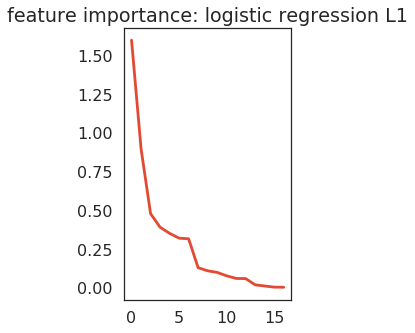

In [361]:
logfullAtable = get_featurename(logistic_selection(dataset['A'],labelset['A'],penalty=2).ravel(),binfeaturenamesplit)

### 1，用logistic regression

Text(0.5,1,'Receiver operating characteristic example')

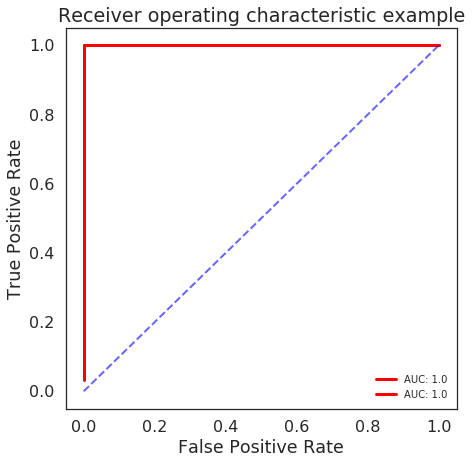

In [362]:
def logistic_roc(feature,label,penalty=2):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for j in range(2):
    roc[j],fpr[j],tpr[j],predict[j]= \
    logistic_roc(dataset[dataclass[j]],labelset[dataclass[j]],penalty=2)
fig,ax=plt.subplots(1,figsize=(7,7))
for j in range(2):
        ax.plot(fpr[j],tpr[j],linewidth=3,color='r',label='AUC: '+str(roc[j]))
ax.legend(prop={'size': 10})
ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')

In [363]:
def logistic_roc(feature,label,penalty=2):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc,fpr, tpr,logmodel.predict(feature)
roc,fpr,tpr,predict = {},{},{},{}
for j in range(2):
    roc[j],fpr[j],tpr[j],predict[j]= \
    logistic_roc(dataset[dataclass[j]][:,:20],labelset[dataclass[j]],penalty=2)

In [364]:
str(np.round(roc[j],3))

'1.0'

Text(0,0.5,'Sensitivity (%)')

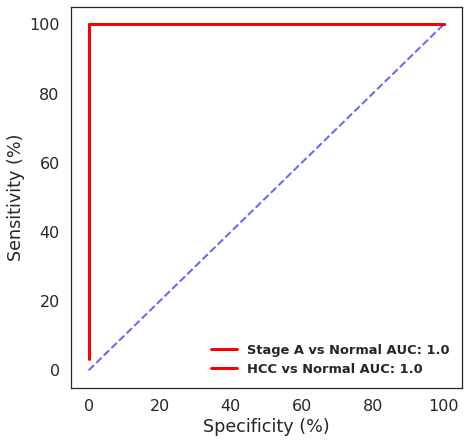

In [365]:
fig,ax=plt.subplots(1,figsize=(7,7))
labesl = ['Stage A vs Normal','HCC vs Normal']
for j in range(2):
    ax.plot(fpr[j]*100,tpr[j]*100,linewidth=3,color='r',label=labesl[j]+' AUC: '+str(np.round(roc[j],3)))
ax.legend(prop={'size': 13,'weight':'bold'})
ax.plot([0,100],[0,100], linewidth=2,alpha=0.6,color='b',linestyle='--')
ax.set_xlabel('Specificity (%)')
ax.set_ylabel('Sensitivity (%)')
#ax.set_title('Receiver operating characteristic')

In [366]:
#forward and RFE

forward:每次找最高的，然后选出来  另用一个range来保证取的feature总是在总index
    

In [367]:
def logistic_selection_(feature,label,penalty=1):
    logmodel = LogisticRegression(penalty='l1',C=penalty)
    logmodel.fit(feature,label)
    return logmodel.coef_

In [368]:
def logistic_selection(feature,label,penalty=0.1):
    logmodel = LogisticRegression(penalty='l2',C=penalty)
    logmodel.fit(feature,label)
    return logmodel.coef_

In [369]:
np.argsort(logistic_selection(dataset['A'],labelset['A']))

array([[1481,  994, 1457, ...,  158,  174,   50]])

In [370]:
ttt = logistic_selection(dataset['A'],labelset['A'])
ttt.shape

(1, 1727)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  1.,  0.,  0.,
         0.,  3.,  3.,  0.,  7.,  6.,  2.,  2.,  7.,  5., 10.,  9.,  8.,
        11.,  8.,  7.,  8., 19., 20., 21., 16., 21., 20., 20., 28., 23.,
        21., 22., 26., 26., 33., 34., 30., 34., 30., 30., 28., 36., 34.,
        27., 44., 26., 31., 25., 24., 38., 36., 29., 25., 30., 28., 26.,
        35., 34., 28., 34., 40., 41., 22., 21., 19., 32., 38., 24., 18.,
        10., 11., 16., 12.,  8., 16., 19., 17., 15., 20., 21., 24., 13.,
        19., 19., 12., 12.,  4.,  3.,  4.,  2.,  1.]),
 array([-0.02884082, -0.02836444, -0.02788806, -0.02741169, -0.02693531,
        -0.02645894, -0.02598256, -0.02550618, -0.02502981, -0.02455343,
        -0.02407706, -0.02360068, -0.0231243 , -0.02264793, -0.02217155,
        -0.02169518, -0.0212188 , -0.02074242, -0.02026605, -0.01978967,
        -0.0193133 , -0.01883692, -0.01836054, -0.01788417, -0.01740779,
        -0.01693142, -0.01645504, -0.01597866, -0.01550229, -0.015025

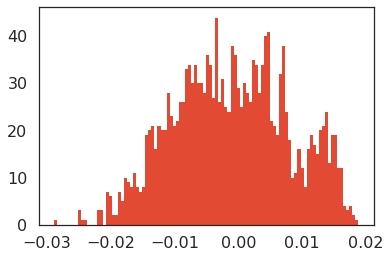

In [371]:
hist(ttt.ravel(),bins=100)

In [372]:
np.sort(logistic_selection(dataset['A'],labelset['A']))

array([[-0.02884082, -0.02479206, -0.02475658, ...,  0.01784995,
         0.01785934,  0.01879678]])

In [373]:
def RFE_logistic(feature,label,step=100,threshold=50):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    originalfeatureind = np.arange(0,featurenum)
    countnum = 0  #count loop
    pbar = tqdm(total = threshold+1)
    while featurenum - step*countnum > threshold:
        #print (countnum)
        #print (featurenum , step*countnum , threshold)
        deleteind = np.argsort(np.abs(logistic_selection(feature[:,originalfeatureind],label))).ravel()[:step]
        originalfeatureind = np.setdiff1d(originalfeatureind,deleteind)
        #print (originalfeatureind.shape ,featureind.shape,deleteind.shape)
        featureind = np.concatenate((featureind,deleteind))
        #if np.where(deleteind==)
        countnum +=1
        #print (featurenum , step*countnum , threshold)
        pbar.update(1)
    pbar.close()
    return originalfeatureind,featureind
originalfeatureind,featureind = RFE_logistic(dataset['A'],labelset['A'],step=10,threshold=50)

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

In [374]:
def logistic_roc(feature,label):
    logmodel = LogisticRegression()
    y_score = logmodel.fit(feature,label).decision_function(feature)
    fpr, tpr, _ = roc_curve(label, y_score)
    roc_auc = auc(fpr, tpr)
    return np.array([roc_auc]), fpr, tpr
roc,fpr,tpr ={},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k] ={},{},{}
    for j in range(2):
        roc[k][j],fpr[k][j],tpr[k][j]=\
        logistic_roc(dataset[dataclass[j]][:,np.flip(featureind.astype('int')[-20:],axis=0)][:,0:(k+1)]  ,labelset[dataclass[j]])


Text(0,0.5,'AUC improvement')

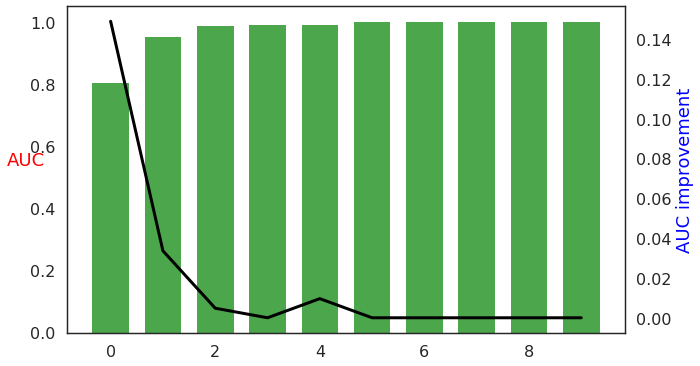

In [375]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][0] for i in range(10)]).ravel(),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
ax2 = ax.twinx()
ax2.plot(np.array([roc[i][0] for i in range(11)])[1:] - np.array([roc[i][0] for i in range(10)]),
       color='black',linewidth=3.0)
ax2.set_ylabel('AUC improvement', color='b',fontsize=18)

In [376]:
def forward_selection(feature,label,step=1,threshold=10):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    countnum = 0  #count loop
    originalfeatureind = np.arange(0,featurenum)
    picked = np.array([])
    pbar = tqdm(total = threshold+1)
    while countnum < threshold:
        #print (countnum)
        auc = np.zeros([featurenum])
        remain = np.setdiff1d(originalfeatureind,picked)
        for i in remain:
            #print ( logistic_roc(feature[:,np.concatenate((featureind,np.array([i]))).astype('int')],label)[0])
            auc[i] = logistic_roc(feature[:,np.concatenate((picked,np.array([i]))).astype('int')],label)[0]
        #print (auc)
        pickfeatureind = originalfeatureind[np.argmax(auc)]
        #print (pickfeatureind)
        #originalfeatureind = np.setdiff1d(originalfeatureind,pickfeatureind)
        #print (pickfeatureind)
        picked = np.concatenate((picked,np.array([pickfeatureind])))
        #print (picked)
        countnum += 1
        pbar.update(1)
    pbar.close()
    return picked.astype('int')

In [377]:
picked = forward_selection(dataset[dataclass[0]][:,np.flip(featureind.astype('int')[-50:],axis=0)] ,
                           labelset[dataclass[0]],step=1,threshold=50)

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

In [378]:
picked

array([ 5,  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [379]:
roc,fpr,tpr ={},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k] ={},{},{}
    for j in range(0,1):
        roc[k][j],fpr[k][j],tpr[k]=\
        logistic_roc(dataset[dataclass[j]][:,picked[0:(k+1)]]  ,labelset[dataclass[j]])

Text(0,0.5,'AUC')

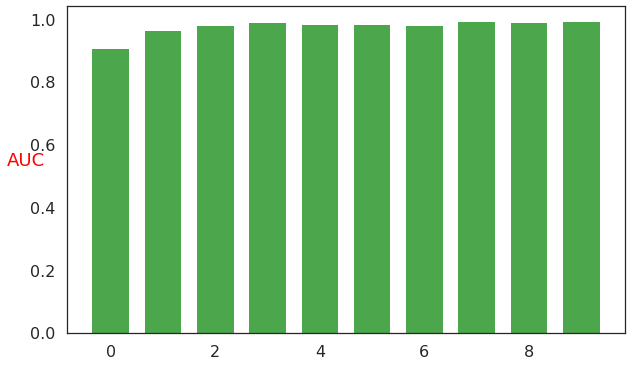

In [380]:
fig,ax=plt.subplots(1,figsize=(10,6))
ax.bar(range(10),np.array([roc[i][0] for i in range(10)]).ravel(),0.7,color='g',alpha=0.7)
ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
#ax2 = ax.twinx()
#ax2.plot(np.array([roc[i][5] for i in range(11)])[1:] - np.array([roc[i][5] for i in range(10)]),
 #      color='black',linewidth=3.0)
#ax2.set_ylabel('AUC improvement', color='b',fontsize=18)

# 8.4
- AUC improvement, feature importance, cluster, 交集与并集
- 对于HCC vs normal，stageA vs Normal两组label
- 在feature上做
- 用RFE和forward整个流程，**在jackknife的基础上做很多次，选出多次重复出现的feature**，然后再画feature importance，画cluster，看挑出来的具体feature

- 挑出来的feature分别
    - 画AUC
    - feature importance
    - clsutering
- 然后比较挑出来的feature的交集和并集，尤其是bin和full的交集！

In [381]:
for j in range(2):
    print (dataclass[j])

A
hcc


In [382]:
def RFE_logistic(feature,label,step=10,threshold=50):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    originalfeatureind = np.arange(0,featurenum)
    countnum = 0  #count loop
    pbar = tqdm(total = threshold+1)
    while featurenum - step*countnum > threshold:
        #print (countnum)
        #print (featurenum , step*countnum , threshold)
        deleteind = np.argsort(np.abs(logistic_selection(feature[:,originalfeatureind],label))).ravel()[:step]
        originalfeatureind = np.delete(originalfeatureind,deleteind)
        #print (originalfeatureind.shape ,featureind.shape,deleteind.shape)
        featureind = np.concatenate((featureind,deleteind))
        #print (featureind.shape)
        #if np.where(deleteind==)
        countnum +=1
        #print (featurenum , step*countnum , threshold)
        pbar.update(1)
    pbar.close()
    return originalfeatureind,featureind

In [383]:
#需要倒着提取
rfefeatureind = {}
for j in tqdm(range(2)):
    rfefeatureind[j] = RFE_logistic(dataset[dataclass[j]],labelset[dataclass[j]],step=10,threshold=50)

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

In [384]:
from tqdm import tqdm

In [385]:
rfefeatureind[0][0]

array([  31,   50,   75,  149,  151,  169,  174,  175,  193,  209,  220,
        221,  224,  406,  511,  545,  645,  865,  868,  914,  994, 1143,
       1166, 1208, 1221, 1244, 1296, 1309, 1314, 1322, 1337, 1369, 1371,
       1406, 1432, 1444, 1453, 1457, 1465, 1475, 1481, 1587, 1601, 1622,
       1658, 1678, 1679])

In [386]:
rfefeatureind[0][0].shape

(47,)

In [387]:
for j in tqdm(range(2)):
    np.savetxt('new_feature/rfe/'+dataclass[j]+'_feature_1.txt',rfefeatureind[j][1],fmt='%d')

100%|██████████| 2/2 [00:00<00:00, 112.93it/s]


In [388]:
rfefeatureind[j][1]

array([1646.,  716., 1186., ...,   17.,   27.,   39.])

In [389]:
def forward_selection(feature,label,step=1,threshold=10):
    featureind = np.array([]) # each loop delete feature ind
    featurenum = feature.shape[1]
    countnum = 0  #count loop
    originalfeatureind = np.arange(0,featurenum)
    picked = np.array([])
    pbar = tqdm(total = threshold+1)
    while countnum < threshold:
        #print (countnum)
        auc = np.zeros([featurenum])
        remain = np.setdiff1d(originalfeatureind,picked)
        for i in remain:
            #print ( logistic_roc(feature[:,np.concatenate((featureind,np.array([i]))).astype('int')],label)[0])
            auc[i] = logistic_roc(feature[:,np.concatenate((picked,np.array([i]))).astype('int')],label)[0]
        #print (auc)
        pickfeatureind = originalfeatureind[np.argmax(auc)]
        #print (pickfeatureind)
        #originalfeatureind = np.setdiff1d(originalfeatureind,pickfeatureind)
        #print (pickfeatureind)
        picked = np.concatenate((picked,np.array([pickfeatureind])))
        #print (picked)
        countnum += 1
        pbar.update(1)
    pbar.close()
    return picked.astype('int')

In [390]:
#需要倒着提取
pickedind = {}
for j in tqdm(range(2)):
    pickedind[j] = forward_selection(dataset[dataclass[j]][:,np.flip(rfefeatureind[j][1].astype('int')[-50:],axis=0)],labelset[dataclass[j]],step=1,threshold=50)
    
    

100%|██████████| 2/2 [00:01<00:00,  1.18it/s]s]


In [391]:
pickedind

{0: array([ 5,  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 1: array([45, 36,  0,  1,  3,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
        15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49])}

In [392]:
#最终forward选出来的feature
np.flip(rfefeatureind[j][1].astype('int')[-50:],axis=0)[pickedind[j]]

array([50, 18, 39, 27, 42, 17, 41, 45, 22, 33, 37, 56, 47, 12,  9, 44,  7,
       64, 32,  3,  4, 46, 35, 38, 63,  5, 53, 43, 28,  2, 71, 46, 22, 58,
       59, 40, 16, 21, 19, 48, 82, 96, 59,  0, 70, 29, 32, 45, 34, 35])

In [393]:
def select_ind4jackknife(indcounts, select_ratio):
    a = np.arange(0,indcounts)
    np.random.shuffle(a)
    return a[:int(indcounts*select_ratio)]
def jackknife_pipeline_feature_version(feature,label,round=10,select_ratio=0.8):
    '''
    each time select select_ratio of all features, do several rounds
    '''
    repeated_feature = np.array([])
    for i in tqdm(range(round)):
        indcounts =  feature.shape[1]
        ind4thisround = select_ind4jackknife(indcounts, select_ratio)
        rfefeatureind = RFE_logistic(feature[:,ind4thisround],label,step=100,threshold=50)
        #需要倒着提取
        pickedind = forward_selection(feature[:,ind4thisround][:,np.flip(rfefeatureind[1].astype('int')[-50:],
                                                                            axis=0)],label,step=1,threshold=50)
        finalind_oneround = ind4thisround[np.flip(rfefeatureind[1].astype('int')[-50:],axis=0)[pickedind]]
        repeated_feature = np.concatenate((repeated_feature,finalind_oneround))
    return repeated_feature.astype('int')

In [418]:
def select_sample4jackknife(indcounts, select_ratio):
    a = np.arange(0,indcounts)
    np.random.shuffle(a)
    return a[:int(indcounts*select_ratio)]
def jackknife_pipeline(feature,label,round=10,select_ratio=0.8):
    '''
    each time select select_ratio of all features, do several rounds
    '''
    repeated_feature = np.array([])
    for i in tqdm(range(round)):
        indcounts =  feature.shape[0]
        sample4thisround = select_sample4jackknife(indcounts, select_ratio)
        #print (sample4thisround)
        rfefeatureind = RFE_logistic(feature[sample4thisround,:],label[sample4thisround],step=5,threshold=50)
        print (rfefeatureind[0].shape)
        #需要倒着提取
        pickedind = forward_selection(feature[sample4thisround,:][:,rfefeatureind[0].astype('int')],label[sample4thisround],step=1,threshold=50)
        print (pickedind.shape)
        #print (np.flip(rfefeatureind[1].astype('int')[-50:],axis=0)[pickedind])
        repeated_feature = np.concatenate((repeated_feature,rfefeatureind[0].astype('int')[pickedind]))
    return repeated_feature.astype('int')

In [419]:
dataset[dataclass[j]].shape,labelset[dataclass[j]].shape

((43, 1727), (43,))

In [ ]:
dataset[dataclass[j]]

In [420]:
repeated_featurehcc = jackknife_pipeline(dataset[dataclass[1]],labelset[dataclass[1]],round=10,select_ratio=0.8)

 80%|████████  | 41/51 [00:00<00:00, 110.73it/s]
62it [00:00, 128.08it/s]                        
84it [00:00, 146.35it/s]
109it [00:00, 166.16it/s]
138it [00:00, 189.50it/s]
171it [00:00, 216.33it/s]
212it [00:00, 251.42it/s]
275it [00:01, 306.23it/s]
336it [00:01, 314.25it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.32it/s]

(47,)



 39%|███▉      | 20/51 [00:00<00:00, 199.81it/s]

(50,)



 82%|████████▏ | 42/51 [00:00<00:00, 203.89it/s]
66it [00:00, 212.11it/s]                        
93it [00:00, 225.73it/s]
122it [00:00, 240.62it/s]
158it [00:00, 266.17it/s]
205it [00:00, 305.32it/s]
283it [00:00, 373.36it/s]
336it [00:00, 397.64it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.55it/s]

(47,)



 37%|███▋      | 19/51 [00:00<00:00, 183.48it/s]

(50,)



 78%|███████▊  | 40/51 [00:00<00:00, 189.04it/s]
63it [00:00, 198.21it/s]                        
88it [00:00, 210.92it/s]
116it [00:00, 227.01it/s]
148it [00:00, 248.16it/s]
188it [00:00, 279.64it/s]
244it [00:00, 328.67it/s]
336it [00:00, 376.97it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.50it/s]

(47,)



 39%|███▉      | 20/51 [00:00<00:00, 193.29it/s]

(50,)



 80%|████████  | 41/51 [00:00<00:00, 197.04it/s]
52it [00:00, 156.39it/s]                        
70it [00:00, 161.24it/s]
93it [00:00, 176.48it/s]
121it [00:00, 198.16it/s]
153it [00:00, 223.43it/s]
192it [00:00, 256.06it/s]
252it [00:00, 308.99it/s]
336it [00:00, 342.37it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.74it/s]

(47,)



 35%|███▌      | 18/51 [00:00<00:00, 172.78it/s]

(50,)



 71%|███████   | 36/51 [00:00<00:00, 174.58it/s]
56it [00:00, 179.78it/s]                        
77it [00:00, 187.87it/s]
100it [00:00, 198.11it/s]
126it [00:00, 212.76it/s]
156it [00:00, 232.87it/s]
193it [00:00, 261.25it/s]
244it [00:00, 305.84it/s]
336it [00:00, 338.13it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.42it/s]

(47,)



 39%|███▉      | 20/51 [00:00<00:00, 192.48it/s]

(50,)



 80%|████████  | 41/51 [00:00<00:00, 196.65it/s]
64it [00:00, 203.65it/s]                        
89it [00:00, 214.16it/s]
117it [00:00, 230.37it/s]
150it [00:00, 252.82it/s]
184it [00:00, 273.15it/s]
233it [00:00, 314.26it/s]
336it [00:00, 368.22it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.70it/s]

(47,)



 37%|███▋      | 19/51 [00:00<00:00, 185.66it/s]

(50,)



 76%|███████▋  | 39/51 [00:00<00:00, 189.07it/s]
60it [00:00, 193.60it/s]                        
83it [00:00, 202.24it/s]
108it [00:00, 214.38it/s]
137it [00:00, 230.94it/s]
170it [00:00, 253.58it/s]
211it [00:00, 285.58it/s]
275it [00:00, 342.23it/s]
336it [00:00, 352.16it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.74it/s]

(47,)



 37%|███▋      | 19/51 [00:00<00:00, 188.50it/s]

(50,)



 76%|███████▋  | 39/51 [00:00<00:00, 190.69it/s]
61it [00:00, 197.38it/s]                        
85it [00:00, 207.09it/s]
112it [00:00, 221.14it/s]
144it [00:00, 242.60it/s]
182it [00:00, 271.41it/s]
231it [00:00, 312.57it/s]
332it [00:00, 394.15it/s]
336it [00:00, 365.88it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.70it/s]

(47,)



 39%|███▉      | 20/51 [00:00<00:00, 190.81it/s]

(50,)



 80%|████████  | 41/51 [00:00<00:00, 193.80it/s]
64it [00:00, 201.69it/s]                        
89it [00:00, 213.39it/s]
117it [00:00, 228.97it/s]
150it [00:00, 250.60it/s]
189it [00:00, 280.26it/s]
245it [00:00, 329.33it/s]
336it [00:00, 376.30it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.73it/s]

(47,)



 39%|███▉      | 20/51 [00:00<00:00, 190.86it/s]

(50,)



 78%|███████▊  | 40/51 [00:00<00:00, 193.32it/s]
62it [00:00, 200.28it/s]                        
87it [00:00, 211.05it/s]
116it [00:00, 228.17it/s]
149it [00:00, 250.36it/s]
189it [00:00, 280.83it/s]
243it [00:00, 327.60it/s]
336it [00:00, 368.53it/s]
  8%|▊         | 4/51 [00:00<00:01, 39.76it/s]

(47,)



100%|██████████| 10/10 [00:16<00:00,  1.62s/it]

(50,)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([65, 17, 13,  8, 12,  5,  5,  7, 11,  5]))

Text(0.5,1,'Feature frequency')

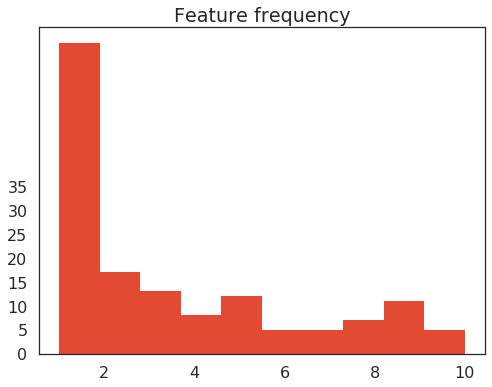

In [408]:
display(np.unique(np.unique(repeated_featurehcc,return_counts=True)[1],return_counts=True))
fig,ax=plt.subplots(1,figsize=(8,6))
ax.hist(np.unique(repeated_featurehcc.astype('int'),return_counts=True)[1],bins=10)
ax.set_yticks(np.arange(0,40,5))
ax.set_title('Feature frequency')

In [470]:
ranked_ind[:,0][[np.argsort(-featureabs)]]

array([ 445,  446,  868,  522, 1436, 1143,  785,  587, 1059,  515,  510,
        948,  586,  603,  942,  297, 1426,  150,  151, 1323, 1438, 1371,
       1383,  175, 1319, 1322, 1422,  822,  914,  123,  170, 1303,  126,
        193,  128, 1133,   33,  109, 1166,  137,  160, 1248,  132, 1455,
         50,  152,  188, 1268,  221,  162,  220,  174,  158, 1309, 1592,
        745, 1026,  845,  901,  818,  516,  161,  545, 1525,  125, 1444,
       1234,  133,  645,   31,    3, 1726, 1244, 1380,  874, 1307, 1443,
       1432,  574, 1358, 1390, 1481, 1596,  865,  772,   34, 1679,  860,
         21, 1212,  836, 1453, 1221, 1369, 1346,   69, 1363, 1647, 1457,
       1696, 1465, 1224, 1678,  849])

In [472]:
featurenamessort

array(['20010', '36105', 'MIRLET7D', 'piR.hsa.27616', 'MEX3C', 'Y_RNA',
       'piR.hsa.619', 'piR.hsa.28390_2', 'Y_RNA', 'piR.hsa.27138',
       'piR.hsa.26872', 'Y_RNA', 'piR.hsa.28390', 'piR.hsa.28634',
       'Y_RNA', 'piR.hsa.1593', 'MIR450B', 'HELLPAR', 'HELLPAR', '1',
       'MIR1250', 'MIR320A', '27556', 'LINC00506', 'MIR195', 'MIR204',
       'AC116407.1', 'MIR345', 'SNORD33', 'AC006548.3', 'SNORD3B-2',
       'MIR497', 'AC006548.3', 'MIR338', 'AC006548.3', 'Y_RNA', 'MIR92B',
       'SNORD3C', 'Y_RNA', 'AP000542.3', 'HELLPAR', 'MIR499A',
       'AC006548.3', 'MIR1287', 'AC022929.2', 'HELLPAR', 'LINC01427',
       'MIR455', 'G032283', 'HELLPAR', 'G032283', 'LINC00506', 'HELLPAR',
       'MIR27A', 'MAEA', 'RSPO1', 'SNORD3B-2', 'MIR22', 'Y_RNA', 'MIR30E',
       'piR.hsa.27139', 'HELLPAR', 'ZC3HAV1', 'AL671511.1', 'AC006548.3',
       'MIR1304', 'MIR19A', 'AP000542.2', 'LINC00670', 'SCARNA15',
       'AC007743.1', 'AC007743.1', 'MIR651', 'RNU11', '1', 'MIR483',
       'SNORD110',

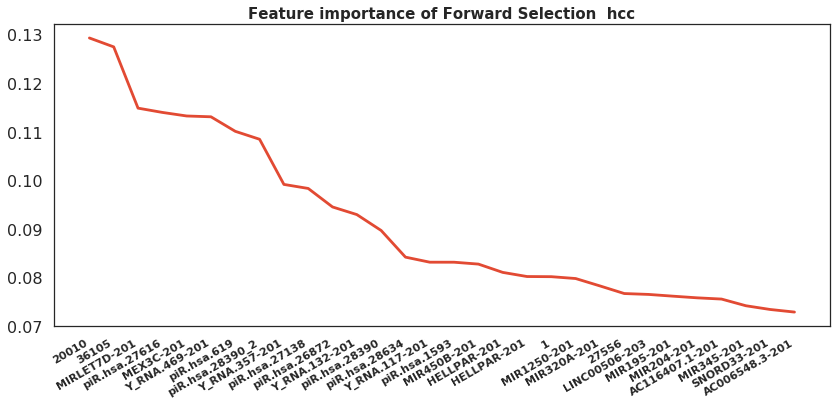

In [480]:
fig,ax=plt.subplots(1,figsize=(12,6))
ranges = 30
featureabs = np.abs(logistic_selection(dataset[dataclass[j]][:,ranked_ind[:,0]]
           ,labelset[dataclass[j]])).ravel()
featurenamessort = binnametranslated[ranked_ind[:,0][[np.argsort(-featureabs)]]]
ax.set_xticks(np.arange(0,ranges))
ax.set_xticklabels(featurenamessort[:ranges],fontweight='bold')
ax.plot(-np.sort(-featureabs)[:ranges])
ax.set_title('Feature importance of Forward Selection '+ ' '+dataclass[j],fontsize=15,fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=11)
fig.tight_layout()

In [409]:
binfeaturenamesplit.shape

(1727,)

In [421]:
np.unique(repeated_featurehcc,return_counts=True)

(array([   3,    4,   21,   31,   33,   34,   50,   69,  109,  111,  122,
         123,  125,  126,  128,  132,  133,  136,  137,  140,  141,  145,
         149,  150,  151,  152,  158,  159,  160,  161,  162,  164,  170,
         174,  175,  188,  193,  214,  215,  220,  221,  233,  235,  245,
         297,  323,  341,  445,  446,  449,  496,  501,  510,  511,  512,
         515,  516,  522,  545,  550,  574,  586,  587,  602,  603,  623,
         645,  745,  772,  774,  775,  778,  785,  796,  818,  822,  836,
         845,  849,  860,  865,  866,  868,  874,  888,  901,  914,  920,
         942,  948,  952,  987,  994, 1008, 1011, 1018, 1021, 1026, 1059,
        1110, 1118, 1133, 1141, 1143, 1166, 1209, 1212, 1213, 1221, 1224,
        1234, 1244, 1248, 1257, 1258, 1260, 1262, 1266, 1268, 1298, 1303,
        1307, 1309, 1319, 1322, 1323, 1326, 1329, 1339, 1343, 1346, 1358,
        1363, 1369, 1371, 1379, 1380, 1383, 1388, 1390, 1406, 1422, 1424,
        1426, 1432, 1436, 1438, 1443, 

In [422]:
np.unique(repeated_featurehcc,return_counts=True)[0][np.where(np.unique(repeated_featurehcc,return_counts=True)[1]>1)]

array([   3,   21,   31,   33,   34,   50,   69,  109,  123,  125,  126,
        128,  132,  133,  137,  150,  151,  152,  158,  160,  161,  162,
        170,  174,  175,  188,  193,  220,  221,  297,  445,  446,  510,
        515,  516,  522,  545,  574,  586,  587,  603,  645,  745,  772,
        785,  818,  822,  836,  845,  849,  860,  865,  868,  874,  901,
        914,  942,  948, 1026, 1059, 1133, 1143, 1166, 1212, 1221, 1224,
       1234, 1244, 1248, 1268, 1303, 1307, 1309, 1319, 1322, 1323, 1346,
       1358, 1363, 1369, 1371, 1380, 1383, 1390, 1422, 1426, 1432, 1436,
       1438, 1443, 1444, 1453, 1455, 1457, 1465, 1481, 1525, 1592, 1596,
       1647, 1678, 1679, 1696, 1726])

In [423]:
np.unique(repeated_featurehcc,return_counts=True)[1][np.where(np.unique(repeated_featurehcc,return_counts=True)[1]>1)]

array([ 8,  8, 24,  3,  5,  6,  3,  2,  4,  2,  7,  3,  2,  2,  3,  8,  9,
        3,  4,  3,  2,  3,  3,  2,  9,  3,  3,  6,  4,  2,  6,  7,  5,  3,
        2,  6,  7,  2,  4,  6,  2,  3,  4,  3,  3,  6,  3,  3,  3,  2,  3,
        3, 10,  4,  3,  7,  2,  3,  2,  5,  2,  5,  5,  2,  4,  2,  2,  4,
        2,  6,  2,  3,  5,  3,  8,  6,  2,  4,  3,  2, 10,  2,  4,  2,  6,
        6,  3, 10,  3,  2,  8,  2,  4,  2,  2,  6,  2,  3,  2,  2,  2,  3,
        2,  2])

In [424]:
selectedind_count = np.concatenate(( np.unique(repeated_featurehcc,return_counts=True)[0][np.where(np.unique(repeated_featurehcc,return_counts=True)[1]>1)].reshape(-1,1),
               np.unique(repeated_featurehcc,return_counts=True)[1][np.where(np.unique(repeated_featurehcc,return_counts=True)[1]>1)].reshape(-1,1)),axis=1)

In [425]:
ranked_ind = selectedind_count[np.argsort(-selectedind_count[:,1])]

In [428]:
ranked_ind.shape

(104, 2)

In [426]:
binfeaturenamesplit[ranked_ind[:,0]].shape

(104,)

In [416]:
binfeaturenamesplit[ranked_ind[:,0]]

array(['peak_1134.ENST00000626826.1_40340_40440',
       'peak_1133.ENST00000626826.1_40020_40100',
       'peak_1026.ENST00000607520.1_3120_3200',
       'peak_1458.piR.hsa.26872_0_27',
       'peak_1155.ENST00000629295.1_1080_1280',
       'peak_1192.T000078_9920_9980',
       'peak_1142.ENST00000626826.1_113360_113600',
       'peak_1191.ENST00000641087.1_3120_3180', 'peak_14.20010_20_86',
       'peak_140.36105_0_40', 'peak_1462.piR.hsa.27138_0_30',
       'peak_1156.ENST00000629295.1_1380_1540',
       'peak_1109.ENST00000623130.1_7060_7240',
       'peak_1469.piR.hsa.27616_0_30',
       'peak_1043.ENST00000612997.1_80_260',
       'peak_1140.ENST00000626826.1_111380_111680',
       'peak_149.ENST00000242351.9_6460_6520',
       'peak_1151.ENST00000628329.1_180_217',
       'peak_1526.piR.hsa.28390_0_30',
       'peak_1029.ENST00000608459.2_60_120',
       'peak_1028.ENST00000607575.3_60_96',
       'peak_1143.ENST00000626826.1_113620_113720',
       'peak_1135.ENST00000626826.1_4

In [417]:
np.savetxt('selected_feature_.txt',binfeaturenamesplit[ranked_ind[:,0]],fmt='%s')

In [282]:
binfeaturenamesplit

array(['peak_1.12979_0_60', 'peak_2.12985_20_72', 'peak_3.12991_20_72',
       ..., 'peak_668;ENST00000385277.1_0_80',
       'peak_1040;ENST00000612171.2_0_68',
       'peak_1183;ENST00000637446.1_0_64'], dtype=object)

In [272]:
repeated_featurehcc

array([1457,   50,   21,   31,   69,  126,  150,  158,  175,  187,  198,
        208,  220,  221,  445,  512,  545,  772,  776,  777,  818,  220,
         34,   31,   38,   76,  109,  122,  126,  128,  132,  137,  150,
        151,  160,  170,  175,  177,  188,  197, 1390,   21,   50,  123,
        132,   69,  126,  151,  193,  150,  175,  206,  214,  220,  238,
        297,  346,  445,  446,  496, 1212, 1143,   31,  122,   50,  128,
        133,  151,  159,  173,  197,  126,  150,  158,  160,  175,  206,
        188,  445,  446,  914, 1143,   31,   95,   50,  109,  123,  150,
        151,  158,  170,  175,  193,  220,  221,  235,  297,  445,  446,
        510,  545,  510,  818,   31,   50,  109,  126,  123,  128,  150,
        151,  160,  175,  188,  193,  220,  221,  445,  446,  515,  914,
        128,   33,  122,  123,  126,  150,  151,  152,  173,  193,  136,
        137,  174,  175,  197,  220,  445,  446,  510,  214,   31,    3,
         21,  123,  125,  150,  151,  152,  159,  1

In [265]:
repeated_featurehcc_20 = jackknife_pipeline(dataset[dataclass[1]],labelset[dataclass[1]],round=20,select_ratio=0.8)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

(47,)


HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

(20,)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 14, 16, 17, 18]),
 array([44, 20, 16,  5,  3,  3,  6,  2,  1,  1,  1,  4,  1,  1,  2]))

(array([64., 21.,  6.,  6.,  3.,  1.,  1.,  4.,  1.,  3.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

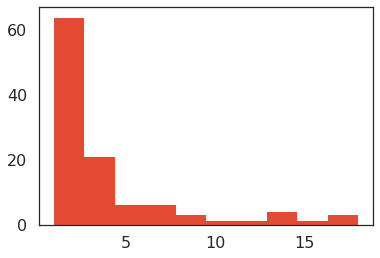

In [267]:
display(np.unique(np.unique(repeated_featurehcc_20,return_counts=True)[1],return_counts=True))
hist(np.unique(repeated_featurehcc_20.astype('int'),return_counts=True)[1],bins=10)

## Jackknife两种feature

## AUC

In [ ]:
roc,fpr,tpr ={},{},{}
for k in range(20):
    roc[k],fpr[k],tpr[k] ={},{},{}
    for j in range(2):
        roc[k][j],fpr[k][j],tpr[k][j]=\
        logistic_roc(dataset[datatype[i]][dataclass[j]][:,
                     np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]][0:(k+1)]]  ,
                     labelset[datatype[i]][dataclass[j]])

In [ ]:
def plot_auc_bar(i,j):
    fig,ax=plt.subplots(1,figsize=(10,6))
    #print (np.array([roc[k][2*i+j] for k in range(10)]))
    ax.bar(range(10),np.array([roc[k][2*i+j] for k in range(10)]).ravel(),0.7,color='g',alpha=0.7)
    ax.set_ylabel('AUC', color='r',rotation=0,fontsize=18)
    ax.set_title('AUC of Forward Feature Selection '+ datatype[i]+' '+dataclass[j])
    ax.set_xticks(np.arange(0,10))
    ax.set_xticklabels(np.arange(0,10))
    #ax2 = ax.twinx()
    #ax2.plot(np.array([roc[k][5] for k in range(11)])[1:] - np.array([roc[k][5] for k in range(10)]),
      # color='black',linewidth=3.0)
    #ax2.set_ylabel('AUC improvement', color='b',fontsize=18)
    #print (np.array([roc[k][5] for k in range(11)])[1:] - np.array([roc[k][5] for k in range(10)]))

In [ ]:
for i in range(3):
    for j in range(2):
        plot_auc_bar(i,j)

## feature importance


In [ ]:
def logistic_selection(feature,label):
    logmodel = LogisticRegression()
    logmodel.fit(feature,label)
    return logmodel.coef_

In [ ]:
dataset[datatype[i]][dataclass[j]][:,
                         np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]

In [ ]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_style(styles[0])
sns.set_context(contexts[2])

In [ ]:
def featureimport(j):
    fig,ax=plt.subplots(1,figsize=(12,6))
    ranges = 20
    featuresnamessort = [fullnametranslated,binnametranslated,mixnametranslated_]
    featureabs = np.abs(logistic_selection(dataset[datatype[i]][dataclass[j]][:,
                     np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
               ,labelset[datatype[i]][dataclass[j]])).ravel()
    featurenamessort = featuresnamessort[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]][np.argsort(-featureabs)]
    ax.set_xticks(np.arange(0,ranges))
    ax.set_xticklabels(featurenamessort[:ranges],fontweight='bold')
    ax.plot(-np.sort(-featureabs)[:ranges])
    ax.set_title('Feature importance of Forward Selection '+ datatype[i]+' '+dataclass[j],fontsize=15,fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=11)
    fig.tight_layout()

In [ ]:
for j in range(2):
    featureimport(i,j)

In [ ]:
fig,ax=plt.subplots(6,1,figsize=(20,60))
ranges = 20
featuresnamessort = [fullnametranslated,binnametranslated,mixnametranslated_]
for i in range(3):
    for j in range(2):
        featureabs = np.abs(logistic_selection(dataset[datatype[i]][dataclass[j]][:,
                         np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
                   ,labelset[datatype[i]][dataclass[j]])).ravel()
        featurenamessort = featuresnamessort[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]][np.argsort(-featureabs)]
        ax[i*2+j].set_xticks(np.arange(0,ranges))
        ax[i*2+j].set_xticklabels(featurenamessort[:ranges],fontweight='bold')
        ax[i*2+j].plot(-np.sort(-featureabs)[:ranges])
        ax[i*2+j].set_title('Feature importance of Forward Selection '+ datatype[i]+' '+dataclass[j],fontsize=25,fontweight='bold')
        plt.setp(ax[i*2+j].get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=12)
        fig.tight_layout()

##   clsutering

In [649]:
stageAnormallabel = np.repeat('sA',29)
stageAnormallabel[labelset[datatype[0]][dataclass[0]].ravel()==0] = 'HD'

In [ ]:
stageAnormallabel

In [ ]:
for i in range(3):
    for j in range(2):
        if j ==0:
            columns1 = stageAnormallabel
       
        elif j==1:
            columns1 = samplecolumns.ravel()
        featurenamesss = [fullnametranslated,binnametranslated,mixnametranslated_]
        if i ==0:
            index1 = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        elif i==1:
            index1 = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        elif i==2:
            index1 = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]

        pd.DataFrame(dataset[datatype[i]][dataclass[j]][:,
                                 np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]].T,
                             columns=columns1,index = index1).to_csv(datatype[i]+dataclass[j]+'_forcluster.csv')

In [ ]:
def cluster_plot(i,j,width=20,height=20):
    rc('font', weight='bold')
    sns.set(font_scale=1)
    if j ==0:
        columns1 = stageAnormallabel
        width = 12
        height = 22
    elif j==1:
        columns1 = samplecolumns.ravel()
        width = 20
        height = 25
    featurenamesss = [fullnametranslated,binnametranslated,mixnametranslated_]
    if i ==0:
        index1 = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
    elif i==1:
        index1 = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
    elif i==2:
        index1 = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        
    table = pd.DataFrame(dataset[datatype[i]][dataclass[j]][:,
                             np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]].T,
                         columns=columns1,index = index1)
    print (table.shape)
    
    cg = sns.clustermap(table,center=0,cmap="vlag",linewidths=.75,figsize=(width,height))
    
    plt.xticks(rotation=0,fontweight='bold') 
    plt.yticks(rotation='vertical',fontweight='bold')
    plt.title('Cluster '+ datatype[i]+' '+dataclass[j],loc ='center')

In [ ]:
for i in range(3):
    for j in range(2):
        cluster_plot(i,j)

## 然后比较挑出来的feature的交集和并集，尤其是bin和full的交集！

In [ ]:
fullfeaturename.shape

In [ ]:
for i in range(3):
    for j in range(2):
        print (dataset[datatype[i]][dataclass[j]].shape)

In [ ]:
fullfeaturename.shape, binfeaturename.shape, mixfeaturename.shape

In [ ]:
selected_feature_name = {}
for i in range(3):
    selected_feature_name[i] = {}
    featurenamesss = [fullnametranslated,binnametranslated,mixnametranslated_]
    for j in range(2):
        if i ==0:
            selected_feature_name[i][j] = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==1:
            selected_feature_name[i][j] = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==2:
            selected_feature_name[i][j] = featurenamesss[i][np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
tablefeature = pd.DataFrame([])
for i in range(3):
    for j in range(2):
        tablefeature =pd.concat((tablefeature,pd.DataFrame(selected_feature_name[i][j])),axis=1)
tablefeature.columns = ['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC']

In [ ]:
np.intersect1d(tablefeature.iloc[:,0],tablefeature.iloc[:,1])

In [ ]:
tablefeature

In [778]:
selected_feature_name_split = {}
for i in range(3):
    selected_feature_name_split[i] = {}
    for j in range(2):
        if i ==0:
            selected_feature_name_split[i][j] = fullfeaturename[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==1:
            selected_feature_name_split[i][j] = binfeaturenamesplit[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
        if i ==2:
            selected_feature_name_split[i][j] = mixfeaturenamesplit[np.flip(rfefeatureind[i][j].astype('int')[-50:],axis=0)[pickedind[i][j]]]
tablefeature_split = pd.DataFrame([])
for i in range(3):
    for j in range(2):
        tablefeature_split =pd.concat((tablefeature_split,pd.DataFrame(selected_feature_name_split[i][j])),axis=1)
tablefeature_split.columns = ['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC']

In [779]:
tablefeature_split

,Full A,Full HCC,Bin A,Bin HCC,Mix A,Mix HCC
0,miRNA_ENSG00000211583.3,miRNA_ENSG00000207738.1,snoRNA_ENSG00000206688.1,lncRNA_ENSG00000263089.1,miRNA_ENSG00000211583.3,miRNA_ENSG00000211583.3
1,lncRNA_ENSG00000280136.2,Y_RNA_ENSG00000202255.1,tRNA_22344,lncRNA_ENSG00000251562.7,lncRNA_ENSG00000280136.2,lncRNA_ENSG00000227492.1
2,miRNA_ENSG00000221586.1,srpRNA_ENSG00000243420.3,miRNA_ENSG00000284553.1,Y_RNA_ENSG00000201343.1,lncRNA_ENSG00000254319.5,srpRNA_ENSG00000243420.3
3,piRNA_piR.hsa.21148_60,lncRNA_ENSG00000167912.5,lncRNA_ENSG00000280156.1,tRNA_12975,piRNA_piR.hsa.26301,snRNA_ENSG00000201291.1
4,lncRNA_ENSG00000264112.1,piRNA_piR.hsa.21148_10,snRNA_ENSG00000201291.1,lncRNA_ENSG00000251562.7,piRNA_piR.hsa.20664_51,snRNA_ENSG00000222414.1
5,lncRNA_ENSG00000223546.6,lncRNA_ENSG00000264112.1,lncRNA_ENSG00000177640.15,lncRNA_ENSG00000246859.2,piRNA_piR.hsa.20664_50,snRNA_ENSG00000272020.1
6,lncRNA_ENSG00000268573.1,lncRNA_ENSG00000249614.1,snRNA_ENSG00000252468.1,lncRNA_ENSG00000272053.1,piRNA_piR.hsa.29477,lncRNA_ENSG00000264112.1
7,piRNA_piR.hsa.21148_10,piRNA_piR.hsa.2621_68,srpRNA_ENSG00000239884.3,lncRNA_ENSG00000269821.1,lncRNA_ENSG00000278913.1,miRNA_ENSG00000207954.1
8,lncRNA_ENSG00000233424.2,piRNA_piR.hsa.21148_67,lncRNA_ENSG00000212978.6,lncRNA_ENSG00000251562.7,lncRNA_ENSG00000258844.1,tRNA_36015
9,tRNA_36015,miRNA_ENSG00000207711.1,lncRNA_ENSG00000279670.1,miRNA_ENSG00000198973.4,miRNA_ENSG00000221586.1,lncRNA_ENSG00000280136.2


In [ ]:
np.intersect1d(tablefeature.iloc[:,2],tablefeature.iloc[:,3])

In [ ]:
np.intersect1d(tablefeature.iloc[:,4],tablefeature.iloc[:,5])

In [ ]:
np.intersect1d(tablefeature_split.iloc[:,0],tablefeature_split.iloc[:,3])

In [ ]:
uniquefeature, unicounts  = np.unique(tablefeature,return_counts=True)
uniquefeature[unicounts>1]
unicounts[unicounts>1]

In [ ]:
np.concatenate((uniquefeature[unicounts>1].reshape(-1,1),unicounts[unicounts>1].reshape(-1,1)),axis=1).shape

In [ ]:
pd.DataFrame(np.concatenate((uniquefeature[np.argsort(-unicounts)].reshape(-1,1),
                             unicounts[np.argsort(-unicounts)].reshape(-1,1)),axis=1)[:-2].reshape(-1,6)
            ,columns=['geneid','frequency','geneid','frequency','geneid','frequency'])

In [ ]:
for i in range(6):
    for j in np.setdiff1d(np.arange(0,6),i):
        print (['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC'][i],['Full A','Full HCC','Bin A','Bin HCC','Mix A','Mix HCC'][j])
        print (np.intersect1d(tablefeature.iloc[:,i],tablefeature.iloc[:,j]))
        print ('\n')